In [1]:
# LABS 3
# Probabilistic Building Blocks

# Part 2 - Sampling in Stan

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import pystan
import stan_utility

In [3]:
# Matplotlib pyplot style configuration

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
blue="#0000FF"
red="#FF0000"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [4]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
#                                                         GAMMA FAMILY DISTRIBUTION
# -------------------------------------------------------------------------------------------------------------------------------------------------

# These distributions are defined for positive real numbers.
# Provide histograms of Gamma and invGamma distributions.
# See how tail behavior of those distributions behave.
# Using albebra_solver (see notebook from lecture on poisson distribution modelling) find parameters for Gamma and invGamma
# for which 98% probability is for values between 5 and 10. Sample for those distributions and compare histograms.

In [5]:
# Dictionary of gamma distribution
gamma_dict_size = 10000
gamma_dict = { "shape_k = 2.0 scale_theta = 1.0" : np.random.gamma(2.0, 1.0, size = gamma_dict_size),
               "shape_k = 2.0 scale_theta = 2.0" : np.random.gamma(2.0, 2.0, size = gamma_dict_size),
               "shape_k = 4.0 scale_theta = 1.0" : np.random.gamma(4.0, 1.0, size = gamma_dict_size),
               "shape_k = 4.0 scale_theta = 2.0" : np.random.gamma(4.0, 2.0, size = gamma_dict_size)
             }
# print(gamma_dict)

In [6]:
# Data frame of gamma distribution
df_gamma_dict = pd.DataFrame.from_dict(gamma_dict)

# print(df_gamma_dict)

In [7]:
# Melted data frame of gamma distribution
df_melted_gamma_dict = df_gamma_dict.melt()

print(df_melted_gamma_dict)

                              variable     value
0      shape_k = 2.0 scale_theta = 1.0  2.207889
1      shape_k = 2.0 scale_theta = 1.0  0.288102
2      shape_k = 2.0 scale_theta = 1.0  0.816795
3      shape_k = 2.0 scale_theta = 1.0  0.692486
4      shape_k = 2.0 scale_theta = 1.0  0.679368
...                                ...       ...
39995  shape_k = 4.0 scale_theta = 2.0  3.525419
39996  shape_k = 4.0 scale_theta = 2.0  4.290970
39997  shape_k = 4.0 scale_theta = 2.0  6.993768
39998  shape_k = 4.0 scale_theta = 2.0  7.035196
39999  shape_k = 4.0 scale_theta = 2.0  3.042980

[40000 rows x 2 columns]


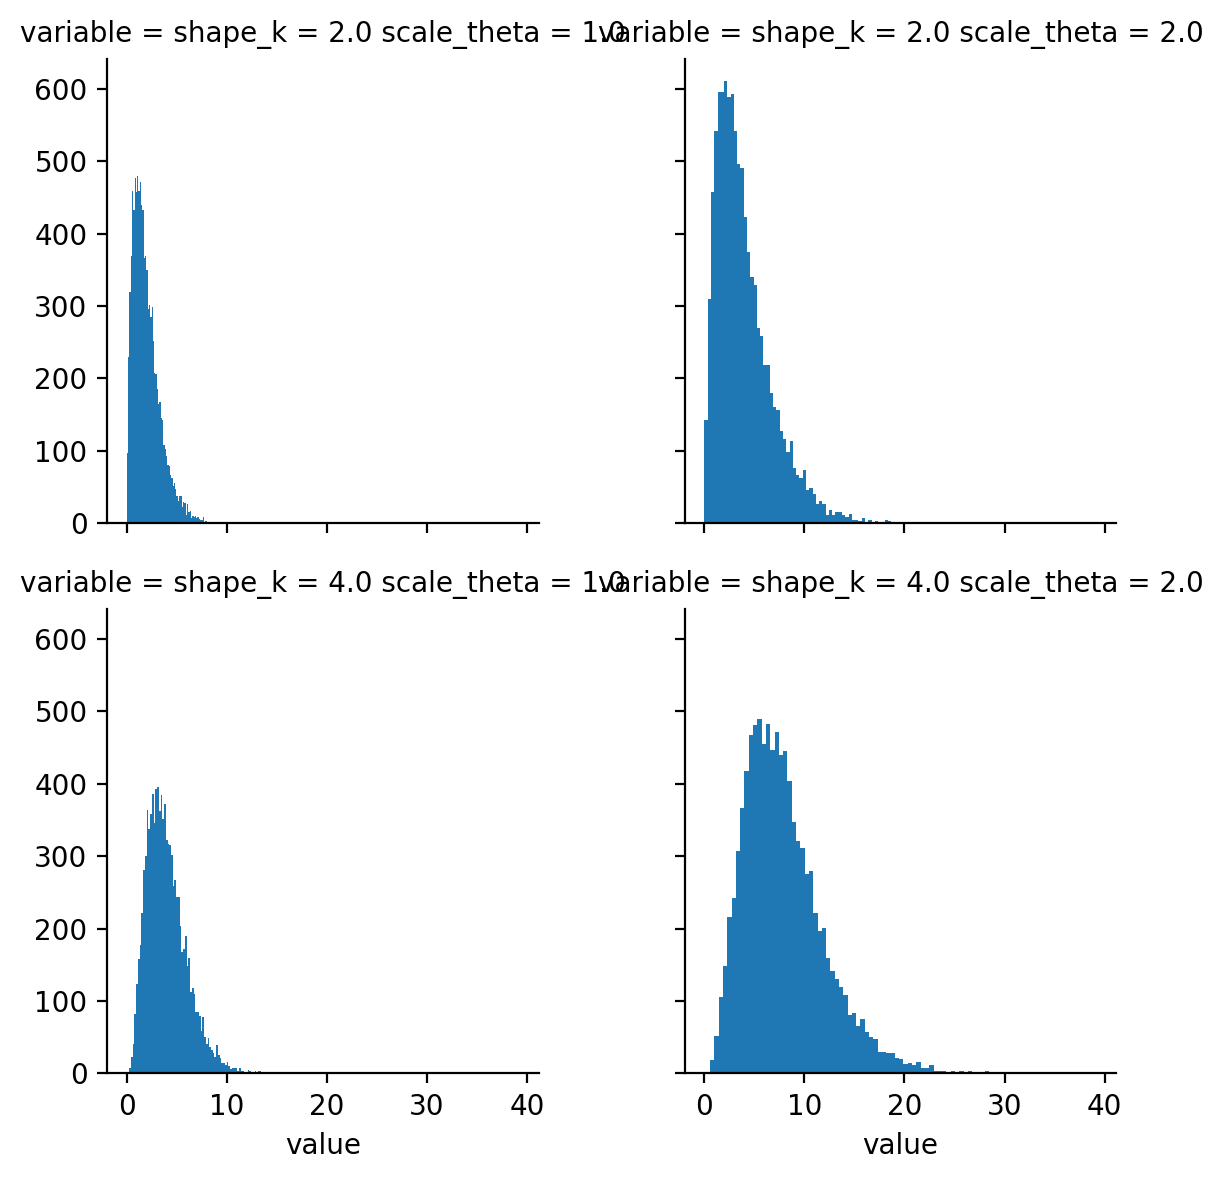

In [8]:
# Histograms of gamma distribution

Graph = sns.FacetGrid(df_melted_gamma_dict, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist,"value", cumulative=False, bins=90)

In [9]:
# GAMMA & INVERSE GAMMA DISTRIBUTION
# Calculations used in plotting

x1 = np.linspace(0,10,10000) # Used in all gamma and inverse gamma distrubutions below

alpha = 2.0
beta  = 1.0
gamma_alpha_2_beta_1     = stats.gamma.pdf(x1, a=alpha, scale=1/beta)
gamma_inv_alpha_2_beta_1 = stats.invgamma.pdf(x1, a=alpha, scale=1/beta)

alpha = 2.0
beta  = 2.0
gamma_alpha_2_beta_2     = stats.gamma.pdf(x1, a=alpha, scale=1/beta)
gamma_inv_alpha_2_beta_2 = stats.invgamma.pdf(x1, a=alpha, scale=1/beta)

alpha = 4.0
beta  = 1.0
gamma_alpha_4_beta_1     = stats.gamma.pdf(x1, a=alpha, scale=1/beta)
gamma_inv_alpha_4_beta_1 = stats.invgamma.pdf(x1, a=alpha, scale=1/beta)

alpha = 4.0
beta  = 2.0
gamma_alpha_4_beta_2     = stats.gamma.pdf(x1, a=alpha, scale=1/beta)
gamma_inv_alpha_4_beta_2 = stats.invgamma.pdf(x1, a=alpha, scale=1/beta)

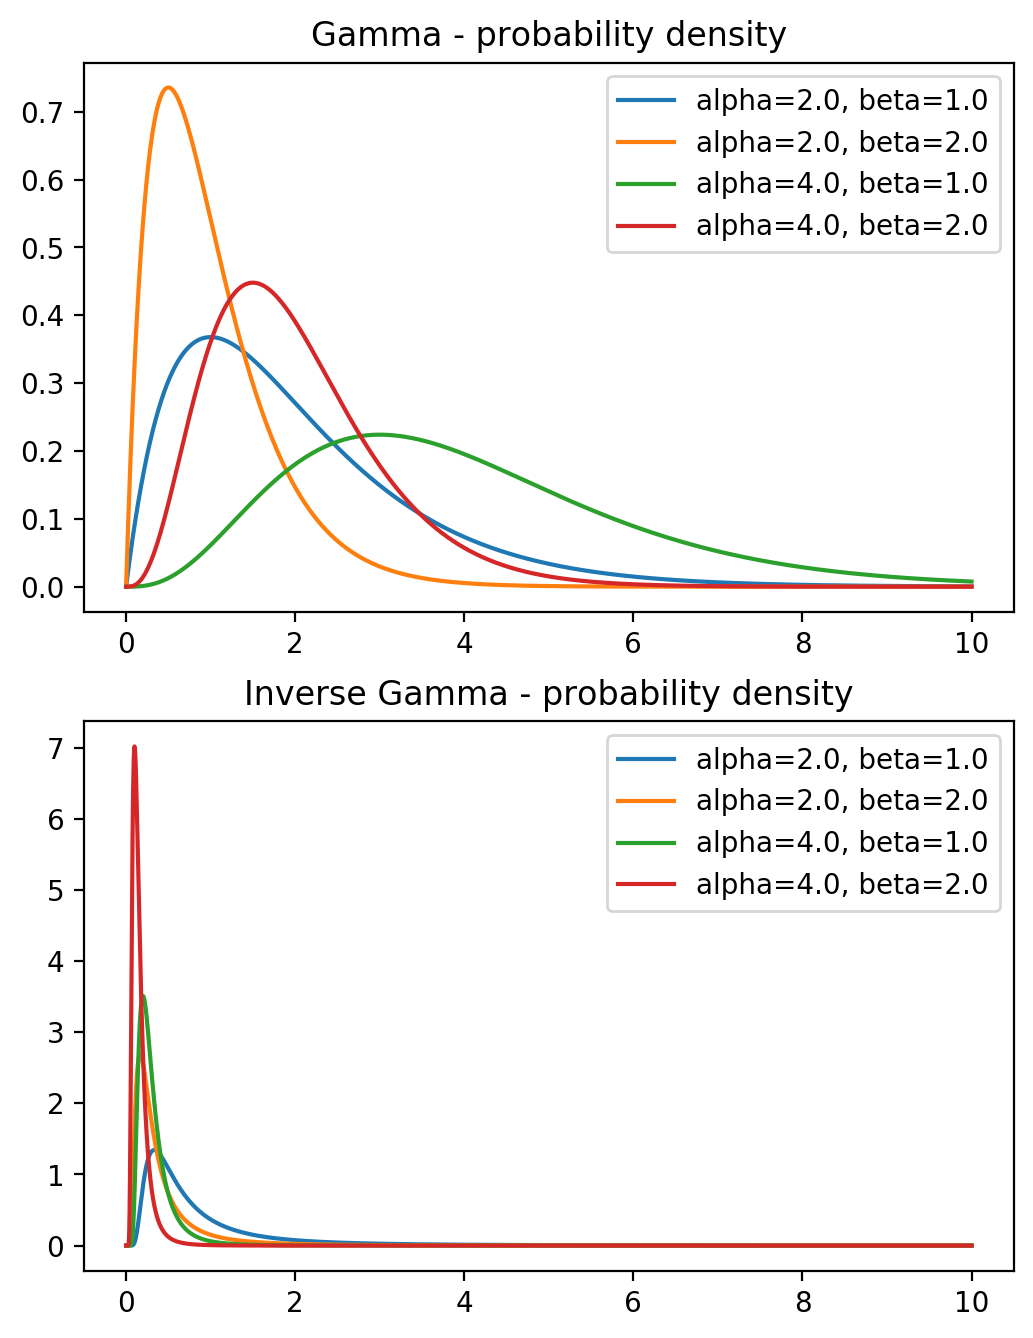

In [10]:
# GAMMA & INVERSE GAMMA DISTRIBUTION
# Plots

plt.figure(figsize=(6,8))

# GAMMA DISTRIBUTION
plt.subplot(2, 1, 1)
plt.plot(x1, gamma_alpha_2_beta_1, label="alpha=2.0, beta=1.0")
plt.plot(x1, gamma_alpha_2_beta_2, label="alpha=2.0, beta=2.0")
plt.plot(x1, gamma_alpha_4_beta_1, label="alpha=4.0, beta=1.0")
plt.plot(x1, gamma_alpha_4_beta_2, label="alpha=4.0, beta=2.0")
plt.legend(loc='upper right')
plt.title("Gamma - probability density")

# INVERSE GAMMA DISTRIBUTION
plt.subplot(2, 1, 2)
plt.plot(x1, gamma_inv_alpha_2_beta_1, label="alpha=2.0, beta=1.0")
plt.plot(x1, gamma_inv_alpha_2_beta_2, label="alpha=2.0, beta=2.0")
plt.plot(x1, gamma_inv_alpha_4_beta_1, label="alpha=4.0, beta=1.0")
plt.plot(x1, gamma_inv_alpha_4_beta_2, label="alpha=4.0, beta=2.0")
plt.legend(loc='upper right')
plt.title("Inverse Gamma - probability density")

plt.show()

In [11]:
# PIOR_TUNE MODEL

# Print file content
with open('prior_tune.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y,       //unknowns
                    vector theta,   //parameters
                    real[] x_r,     // data(real)
                    int[] x_i) {    //data(integer)
    vector[2] deltas;
    // At the end we will receive distribution from 5 to 10 with 98% probability
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) - 0.99;
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) - 0.01;
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of Gaussian standard deviation
  vector<lower=0>[2] theta;   // Target quantile
}

transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Find gamma parameters that ensures 98% probabilty from 5 to 10
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i, 1e-10, 1e-3, 1e3); // last 3 parameters are tolerances, middle one was changed due to occuring error, not recomended solution but it works

  print("Alpha  = ", y[1]);
  print("Beta = ", y[2]);
}

generated quantities {
 

In [12]:
# Build model based on algebra_solver file
model_prior = stan_utility.compile_model('prior_tune.stan')

Using cached StanModel


In [13]:
# (...) for values between 5 and 10
data = dict(y_guess   = np.array([1, 0.1]),
            theta     = np.array([10, 5]))

# Sample for those distributions
sim_prior = model_prior.sampling(data   = data,
                              seed      = 1052020,
                              algorithm = "Fixed_param",
                              iter      = 1,
                              warmup    = 0,
                              chains    = 1)

In [14]:
alpha = np.round(sim_prior.extract()['alpha'][0])
beta  = np.round(sim_prior.extract()['beta'][0])

print("Alpha:", alpha, " Beta:", beta)

Alpha: 46.0  Beta: 6.0


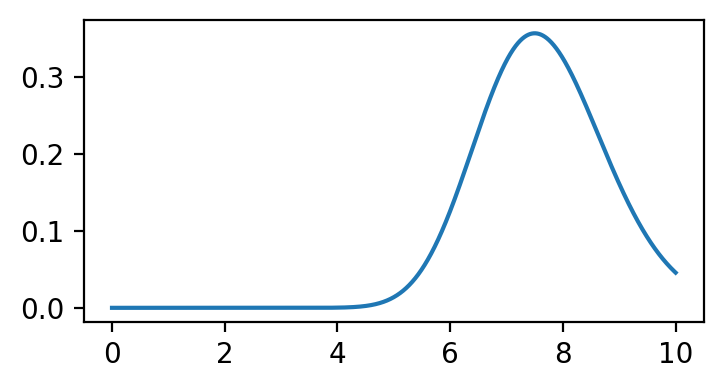

In [15]:
# Plot of gamma distrubution
# Parameters are taken from model (prior_tune.stan)

x1 = np.linspace(0,10,10000)

gamma_alpha_beta = stats.gamma.pdf(x1, a=alpha, scale=1/beta)

plt.figure(figsize=(4,2))
plt.plot(x1, gamma_alpha_beta)

plt.show()

In [16]:
# GAMMA MODEL

# Print file content
with open('gamma.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> alpha; // Shape
    real<lower=0> beta; // Inverse scale
}

parameters {
    real y;
}

model {
    y ~ gamma(alpha, beta);
}


In [17]:
gamma_model = stan_utility.compile_model('gamma.stan')

Using cached StanModel


In [18]:
sim_gamma = gamma_model.sampling(data   = {'alpha': alpha,
                                           'beta': beta},
                                 iter   = 10000,
                                 chains = 1,
                                 seed   = 42342)
gamma_model_results = sim_gamma.extract()

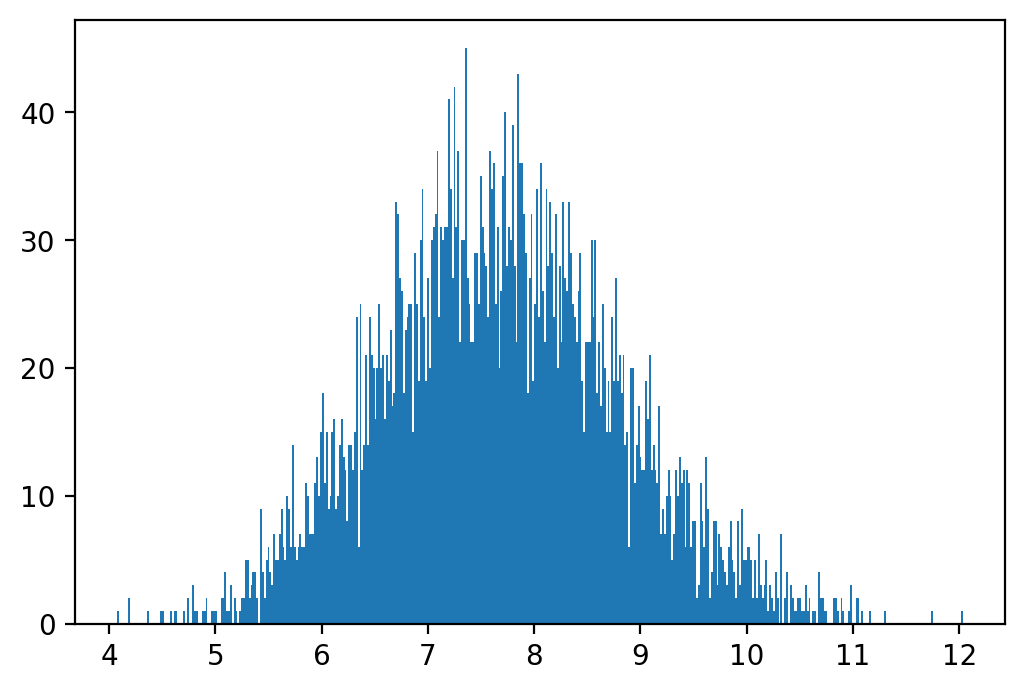

In [19]:
# Histogram of gamma distribution
# Parameters are taken from model (gamma.stan)

gamma_hist = plt.hist(gamma_model_results['y'], bins=450)

In [20]:
# GAMMA & INVERSE GAMMA DISTRIBUTION
# 98% probability is for values between 5 and 10
# Based on model (gamma.stan)
# Calculations used in plotting

x_1 = np.arange(stats.gamma.ppf(0.01, alpha, beta),
                stats.gamma.ppf(0.99, alpha, beta))
x_2 = stats.gamma.pdf(x_1,alpha,beta)

x1 = np.linspace(5,10)
x2 = stats.gamma.pdf(x1,alpha,beta)

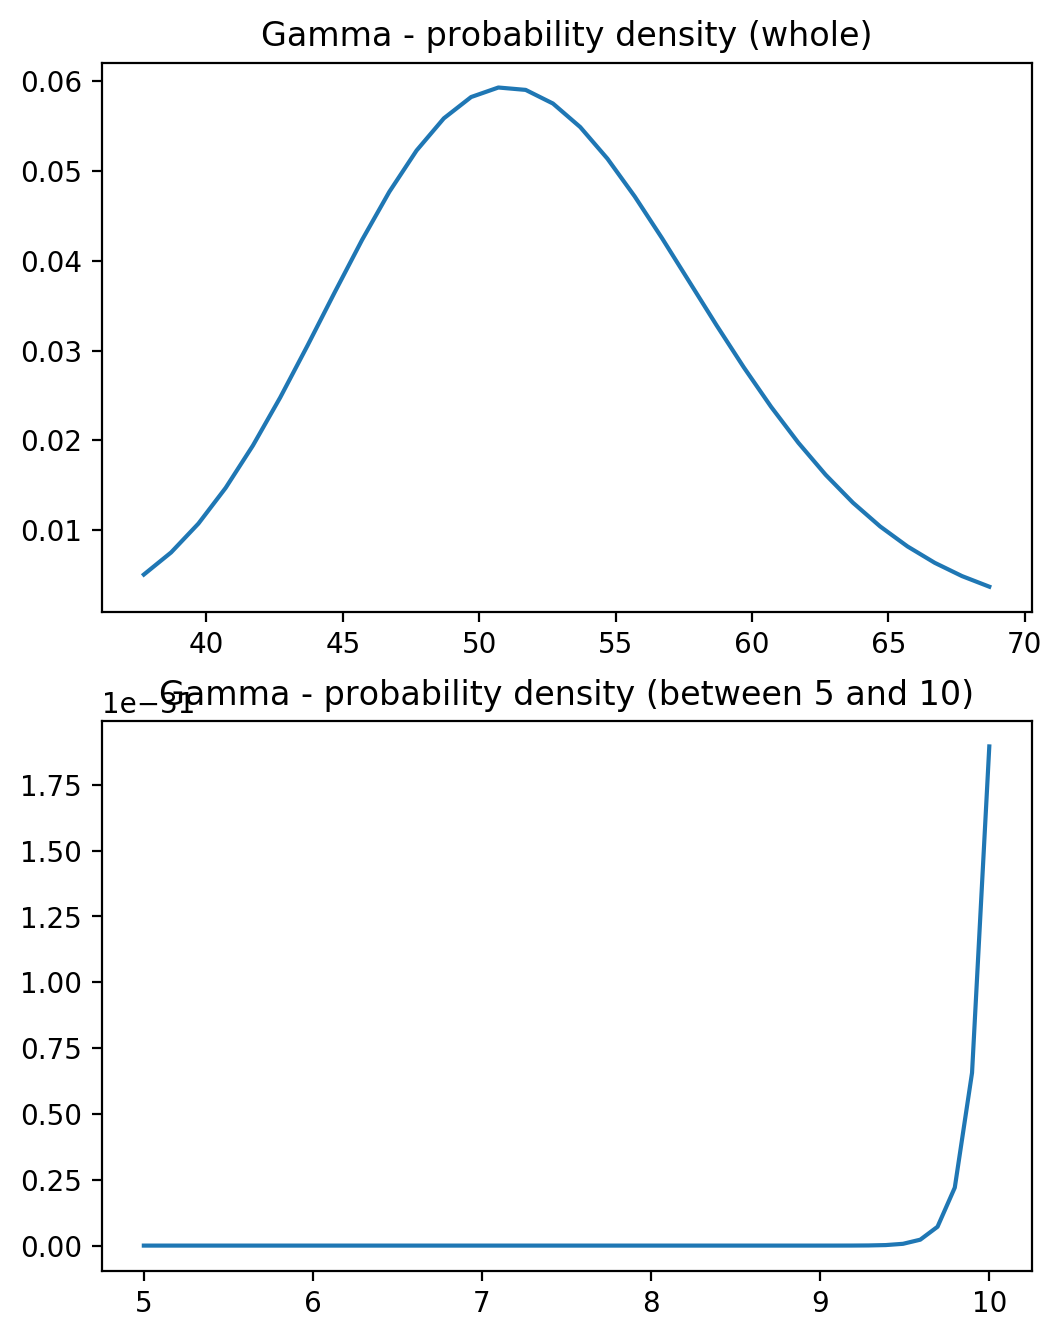

In [21]:
# GAMMA DISTRIBUTION
# 98% probability is for values between 5 and 10
# Based on model (gamma.stan)
# Plots

plt.figure(figsize=(6,8))

plt.subplot(2, 1, 1)
plt.plot(x_1, x_2)
plt.title("Gamma - probability density (whole)")

plt.subplot(2, 1, 2)
plt.plot(x1, x2)
plt.title("Gamma - probability density (between 5 and 10)")

plt.show()

In [22]:
# Print file content
with open('prior_tune_inv.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y,       //unknowns
                    vector theta,   //parameters
                    real[] x_r,     // data(real)
                    int[] x_i) {    //data(integer)
    vector[2] deltas;
    // At the end we will receive distribution from 5 to 10 with 98% probability
    deltas[1] = inv_gamma_cdf(theta[1], y[1], y[2]) - 0.99;
    deltas[2] = inv_gamma_cdf(theta[2], y[1], y[2]) - 0.01;
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of Gaussian standard deviation
  vector<lower=0>[2] theta;   // Target quantile
}

transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Find gamma parameters that ensures 98% probabilty from 5 to 10
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i, 1e-10, 2e-3, 1e3); // last 3 parameters are tolerances, middle one was changed due to occuring error, not recomended solution but it works

  print("Alpha  = ", y[1]);
  print("Beta = ", y[2]);
}

generated quanti

In [23]:
# Build model based on algebra_solver file
model_inv_prior_inv = stan_utility.compile_model('prior_tune_inv.stan')

Using cached StanModel


In [24]:
# (...) for values between 5 and 10
data = dict(y_guess = np.array([0.1, 0.1]),
            theta   = np.array([10, 5]))

# Sample for those distributions
sim_inv_prior = model_inv_prior_inv.sampling(data      = data,
                                          seed      = 1052020,
                                          algorithm = "Fixed_param",
                                          iter      = 1,
                                          warmup    = 0,
                                          chains    = 1)

In [25]:
alpha_inv = np.round(sim_inv_prior.extract()['alpha'][0])
beta_inv  = np.round(sim_inv_prior.extract()['beta'][0])

print("Alpha:", alpha_inv, "Beta:", beta_inv)

Alpha: 47.0 Beta: 322.0


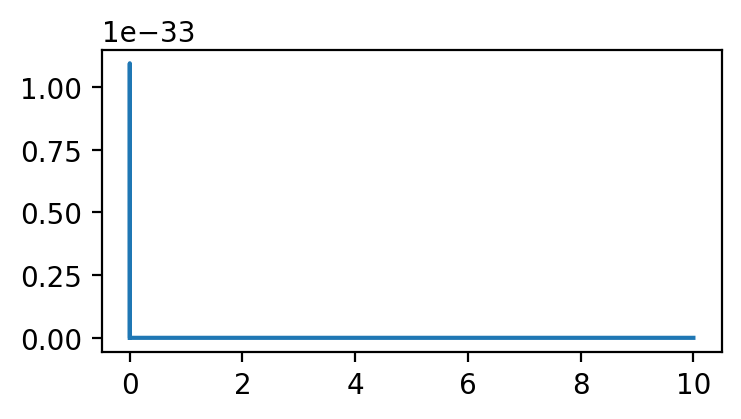

In [26]:
# Plot of gamma distrubution
# Parameters are taken from model (prior_tune_inv.stan)

x1 = np.linspace(0,10,10000)

gamma_inv_alpha_beta = stats.invgamma.pdf(x1, a=alpha_inv, scale=1/beta_inv)

plt.figure(figsize=(4,2))
plt.plot(x1, gamma_inv_alpha_beta)

plt.show()

In [27]:
# INVERSE GAMMA MODEL

# Print file content
with open('gamma_inv.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> alpha; // Shape
    real<lower=0> beta; // Inverse scale
}

parameters {
    real y;
}

model {
    y ~ inv_gamma(alpha, beta);
}


In [28]:
gamma_model_inv = stan_utility.compile_model('gamma_inv.stan')

Using cached StanModel


In [29]:
sim_inv_gamma = gamma_model_inv.sampling(data   = {'alpha': alpha_inv,
                                                   'beta': beta_inv},
                                         iter   = 10000,
                                         chains = 1,
                                         seed   = 42342)
inv_gamma_model_results = sim_inv_gamma.extract()

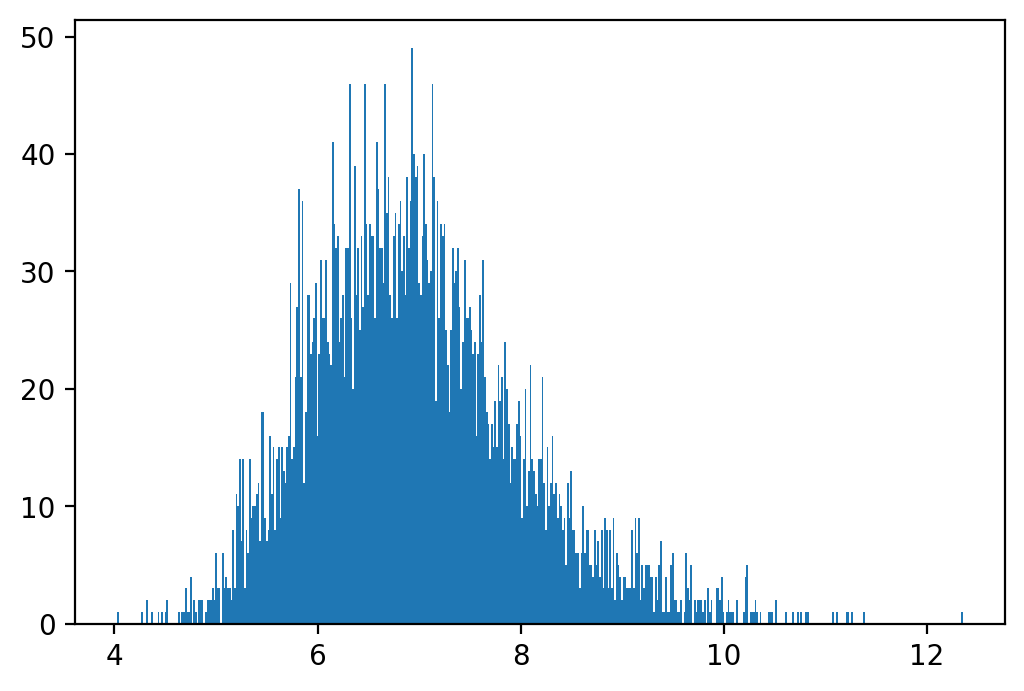

In [30]:
# Histogram of inverse gamma distribution
# Parameters are taken from model (gamma_inv.stan)

inv_gamma_hist = plt.hist(inv_gamma_model_results['y'], bins=500)

In [31]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
#                                                         NEGATIVE BINOMIAL DISTRIBUTION
# -------------------------------------------------------------------------------------------------------------------------------------------------

# Negative binomial distribution can be used in order to relax the constraints of equal mean and variance of Poissson distribution.
# Using both concentration and dispersion parametrization sample from negative binomial with fixed mean and
# see how it behaves in comparison to the Poisson with the same mean.

In [32]:
# Dictionary of binomial distribution
binomial_dict_size = 10000

binomial_dict = { "Binomial p = 0.5 n = 20" : np.random.binomial(20, 0.5, size = binomial_dict_size),
                  "Binomial p = 0.5 n = 40" : np.random.binomial(40, 0.5, size = binomial_dict_size),
                  "Binomial p = 0.7 n = 20" : np.random.binomial(20, 0.7, size = binomial_dict_size),
                  "Binomial p = 0.7 n = 40" : np.random.binomial(40, 0.7, size = binomial_dict_size),
                }
# print(binomial_dict)

In [33]:
# Data frame of binomial distribution
df_binomial_dict = pd.DataFrame.from_dict(binomial_dict)

In [34]:
# Melted data frame of binomial distribution
df_melted_binomial_dict = df_binomial_dict.melt()

print(df_melted_binomial_dict)

                      variable  value
0      Binomial p = 0.5 n = 20     10
1      Binomial p = 0.5 n = 20      8
2      Binomial p = 0.5 n = 20      8
3      Binomial p = 0.5 n = 20     10
4      Binomial p = 0.5 n = 20      8
...                        ...    ...
39995  Binomial p = 0.7 n = 40     30
39996  Binomial p = 0.7 n = 40     22
39997  Binomial p = 0.7 n = 40     27
39998  Binomial p = 0.7 n = 40     25
39999  Binomial p = 0.7 n = 40     28

[40000 rows x 2 columns]


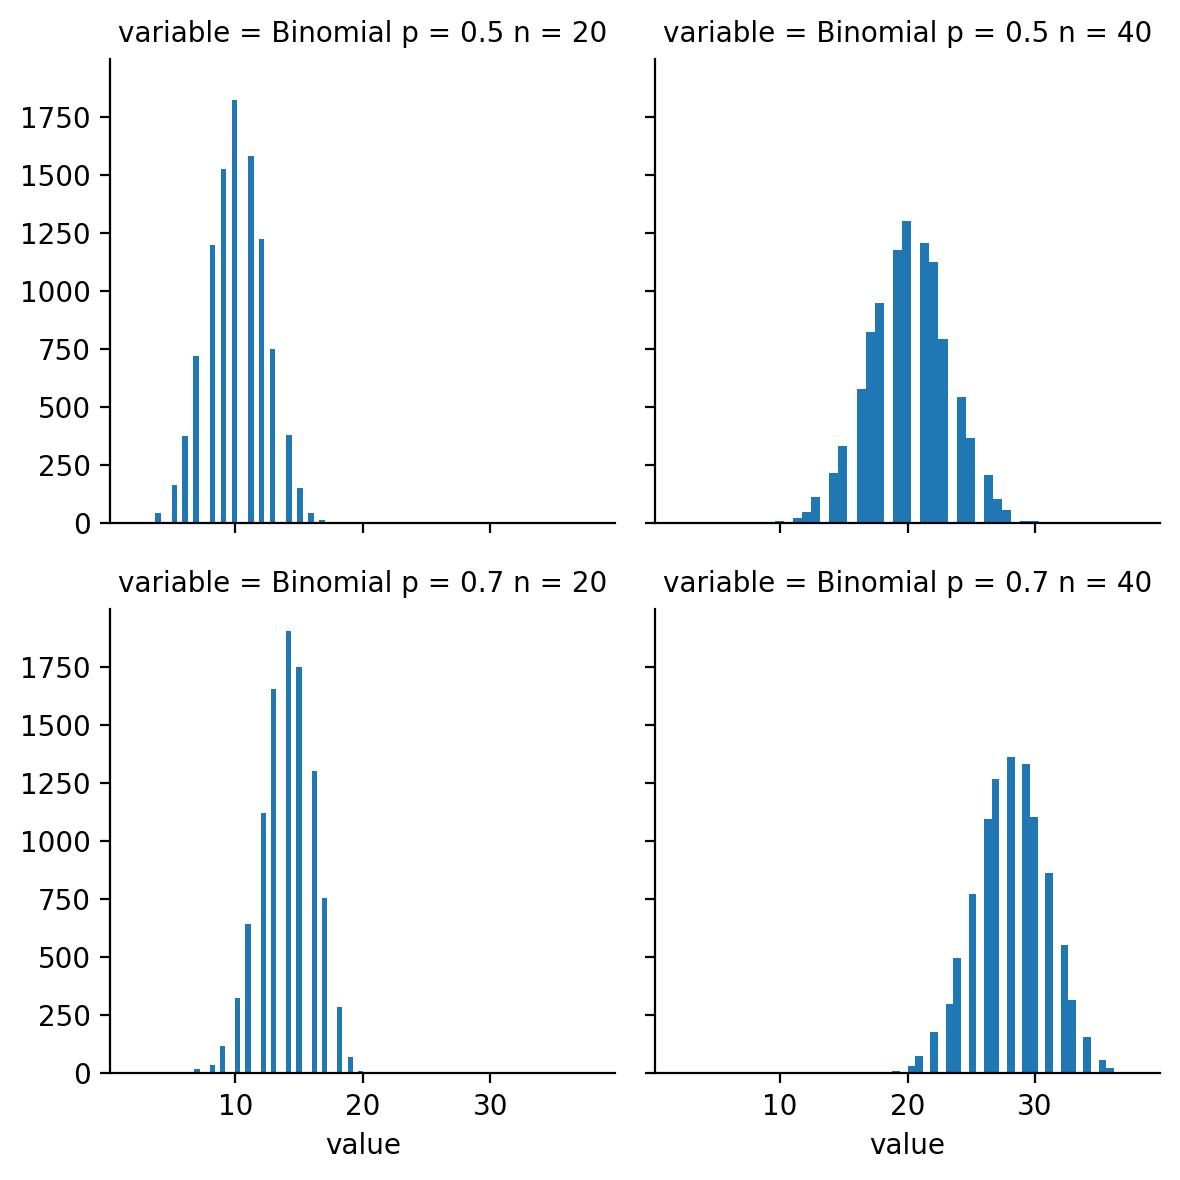

In [35]:
# Histograms of binomial distribution

Graph = sns.FacetGrid(df_melted_binomial_dict, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=35)

In [36]:
# Dictionary of negative binomial distribution
neg_binomial_dict_size = 10000

neg_binomial_dict = { "Negative binomial p = 0.5 n = 20" : np.random.negative_binomial(20, 0.5, size = neg_binomial_dict_size),
                      "Negative binomial p = 0.5 n = 40" : np.random.negative_binomial(40, 0.5, size = neg_binomial_dict_size),
                      "Negative binomial p = 0.7 n = 20" : np.random.negative_binomial(20, 0.7, size = neg_binomial_dict_size),
                      "Negative binomial p = 0.7 n = 40" : np.random.negative_binomial(40, 0.7, size = neg_binomial_dict_size),
                    }
# print(neg_binomial_dict)

In [37]:
# Data frame of negative binomial distribution
df_neg_binomial_dict = pd.DataFrame.from_dict(neg_binomial_dict)

# print(df_neg_binomial_dict)

In [38]:
# Melted data frame of negative binomial distribution
df_melted_neg_binomial_dict = df_neg_binomial_dict.melt()

print(df_melted_neg_binomial_dict)

                               variable  value
0      Negative binomial p = 0.5 n = 20     18
1      Negative binomial p = 0.5 n = 20     16
2      Negative binomial p = 0.5 n = 20     14
3      Negative binomial p = 0.5 n = 20     24
4      Negative binomial p = 0.5 n = 20     24
...                                 ...    ...
39995  Negative binomial p = 0.7 n = 40     16
39996  Negative binomial p = 0.7 n = 40     15
39997  Negative binomial p = 0.7 n = 40     36
39998  Negative binomial p = 0.7 n = 40     18
39999  Negative binomial p = 0.7 n = 40     21

[40000 rows x 2 columns]


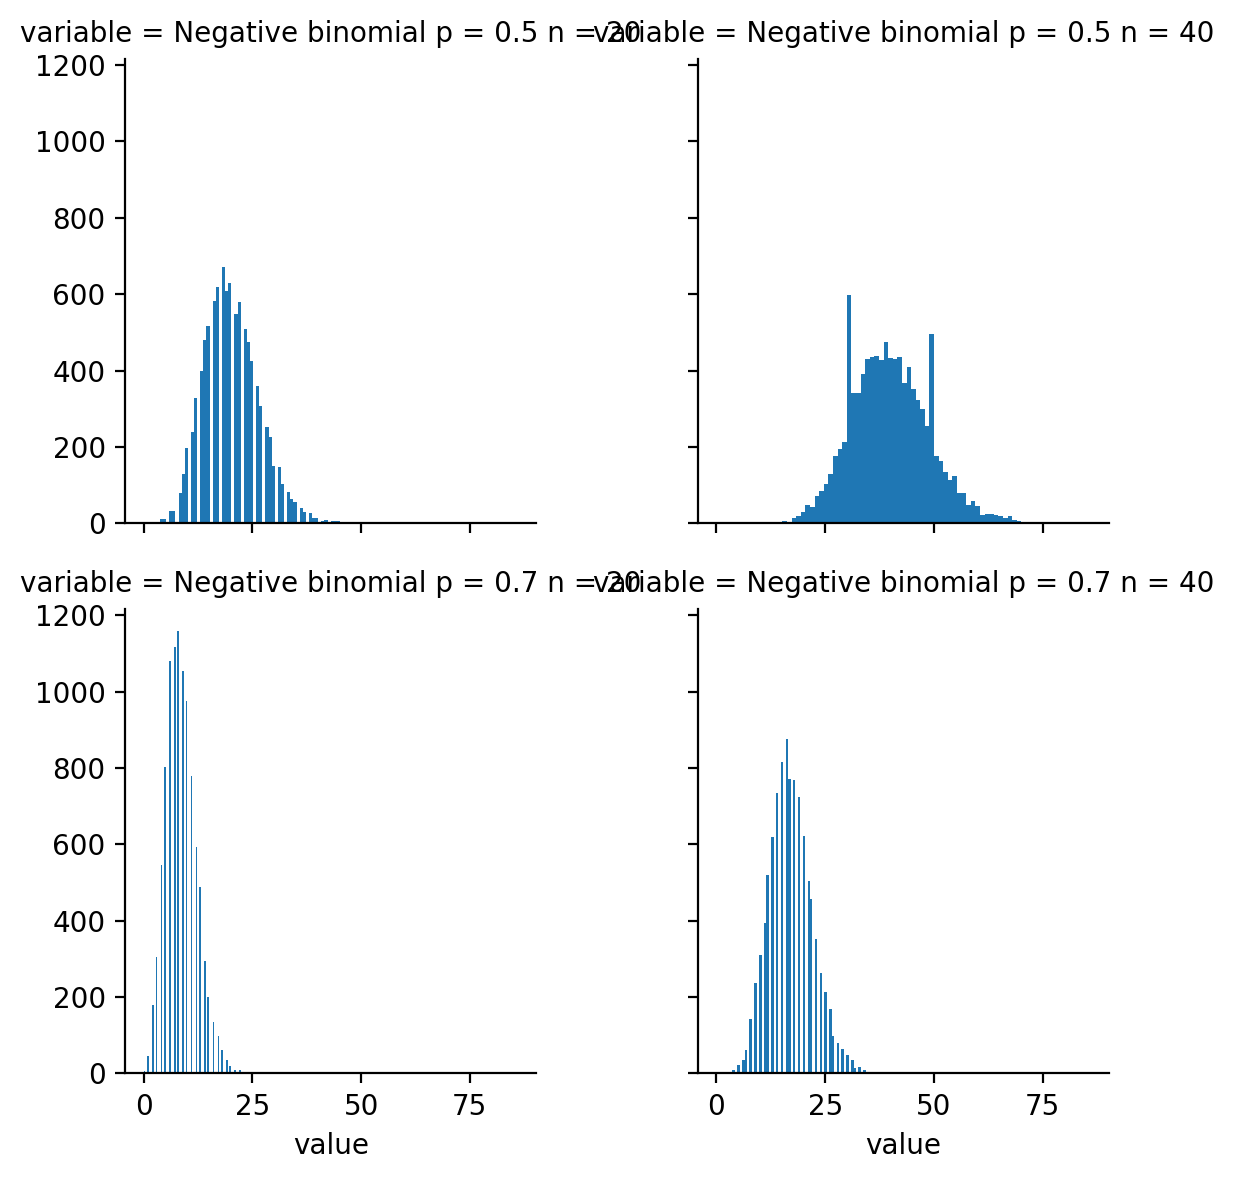

In [39]:
# Histogram of negative binomial distribution

Graph = sns.FacetGrid(df_melted_neg_binomial_dict, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=70)

In [40]:
# COMPARISON OF NEGATIVE BINOMIAL AND POISSON DISTRIBUTION

# Parameters
p = [0.2, 0.4, 0.6, 0.8] # Probability of success; Negative binomial distribution
n = 100 # Number of trials; Negative binomial distribution

u = [] # lambda; Poisson distribution
for x in p:
    u.append(stats.nbinom.mean(n, x)) # Lambda is a mean

In [41]:
# Dictionary of negative binomial distribution
neg_binomial_dict_size = 10000

neg_binomial_dict_com = { "Negative binomial n = 100 p = {}".format(p[0]) : np.random.negative_binomial(n, p[0], size = neg_binomial_dict_size),
                          "Negative binomial n = 100 p = {}".format(p[1]) : np.random.negative_binomial(n, p[1], size = neg_binomial_dict_size),
                          "Negative binomial n = 100 p = {}".format(p[2]) : np.random.negative_binomial(n, p[2], size = neg_binomial_dict_size),
                          "Negative binomial n = 100 p = {}".format(p[3]) : np.random.negative_binomial(n, p[3], size = neg_binomial_dict_size),
                        }

In [42]:
# Data frame of negative binomial distribution
df_neg_binomial_dict_com = pd.DataFrame.from_dict(neg_binomial_dict_com)

# print(df_neg_binomial_dict_com)

In [43]:
# Melted data frame of negative binomial distribution
df_melted_neg_binomial_dict_com = df_neg_binomial_dict_com.melt()

print(df_melted_neg_binomial_dict_com)

                                variable  value
0      Negative binomial n = 100 p = 0.2    429
1      Negative binomial n = 100 p = 0.2    485
2      Negative binomial n = 100 p = 0.2    423
3      Negative binomial n = 100 p = 0.2    399
4      Negative binomial n = 100 p = 0.2    378
...                                  ...    ...
39995  Negative binomial n = 100 p = 0.8     25
39996  Negative binomial n = 100 p = 0.8     40
39997  Negative binomial n = 100 p = 0.8     15
39998  Negative binomial n = 100 p = 0.8     20
39999  Negative binomial n = 100 p = 0.8     36

[40000 rows x 2 columns]


In [44]:
# Dictionary of poisson distribution
poisson_dict_size = neg_binomial_dict_size

poisson_dict_com = { "Poisson u = {}".format(u[0]) : np.random.poisson(u[0], size = poisson_dict_size),
                     "Poisson u = {}".format(u[1]) : np.random.poisson(u[1], size = poisson_dict_size),
                     "Poisson u = {}".format(u[2]) : np.random.poisson(u[2], size = poisson_dict_size),
                     "Poisson u = {}".format(u[3]) : np.random.poisson(u[3], size = poisson_dict_size),
                   }

In [45]:
# Data frame of poisson distribution
df_poisson_dict_com = pd.DataFrame.from_dict(poisson_dict_com)

# print(df_poisson_dict_com)

In [46]:
# Melted data frame of poisson distribution
df_melted_poisson_dict_com = df_poisson_dict_com.melt()

print(df_melted_poisson_dict_com)

                variable  value
0      Poisson u = 400.0    425
1      Poisson u = 400.0    430
2      Poisson u = 400.0    415
3      Poisson u = 400.0    419
4      Poisson u = 400.0    408
...                  ...    ...
39995   Poisson u = 25.0     32
39996   Poisson u = 25.0     19
39997   Poisson u = 25.0     25
39998   Poisson u = 25.0     19
39999   Poisson u = 25.0     22

[40000 rows x 2 columns]


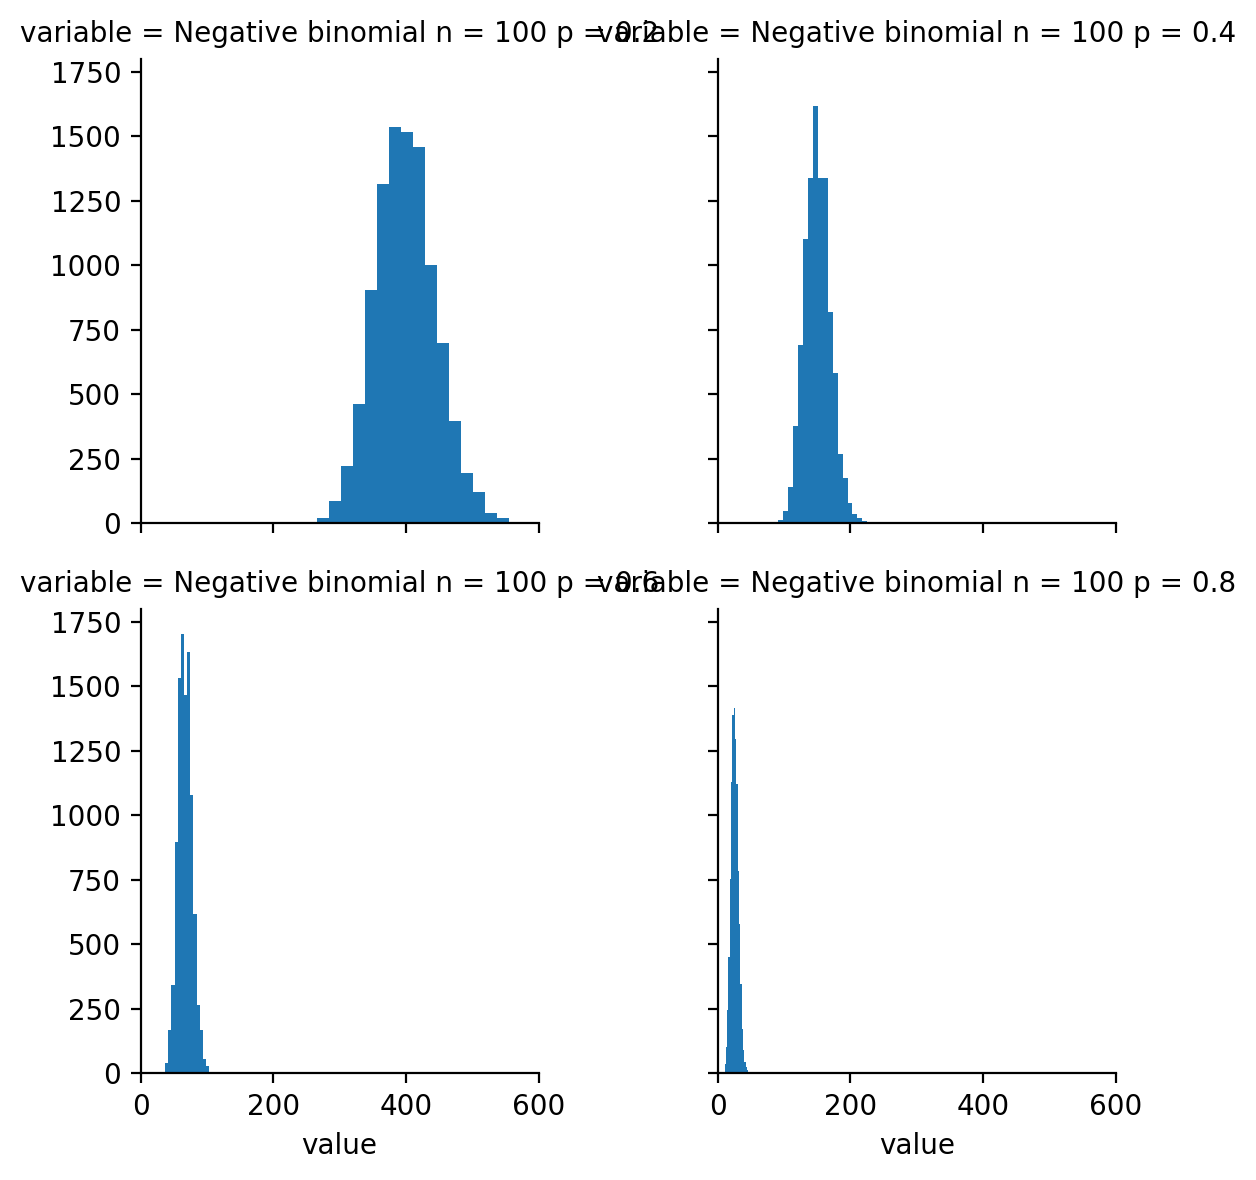

In [47]:
# Histograms of negative binomial distribution

Graph = sns.FacetGrid(df_melted_neg_binomial_dict_com, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)
Graph.set(xlim=(0, 600), ylim=(0, 1800))

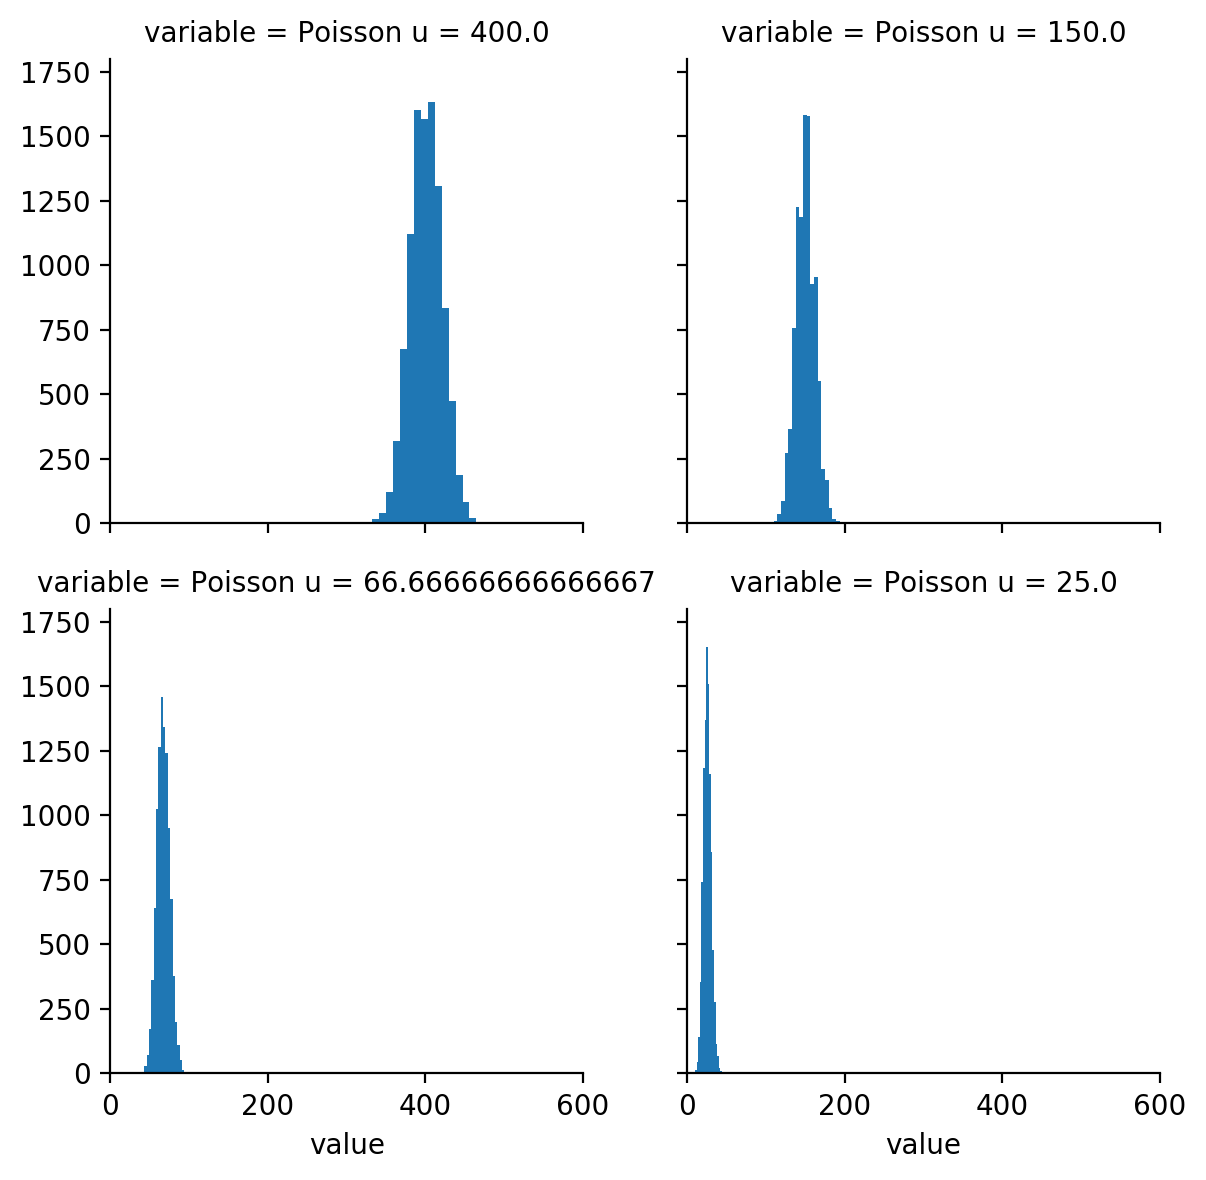

In [48]:
# Histograms of poisson distribution

Graph = sns.FacetGrid(df_melted_poisson_dict_com, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)
Graph.set(xlim=(0, 600), ylim=(0, 1800))

In [49]:
# Any differences between negative binomial distribution and poisson distribution with the same parameters is hardly visible.
# Without prior knowledge which distribution is which one, I could only guess

In [50]:
# NEGATIVE BINOMIAL & POISSON DISTRIBUTION
# Calculations used in plotting

x = np.arange(stats.nbinom.ppf(0.001, n, p[1]),
              stats.nbinom.ppf(0.999, n, p[1]))

neg_binomial = stats.nbinom.pmf(x, n, p[1])
poisson = stats.poisson.pmf(x, u[1])

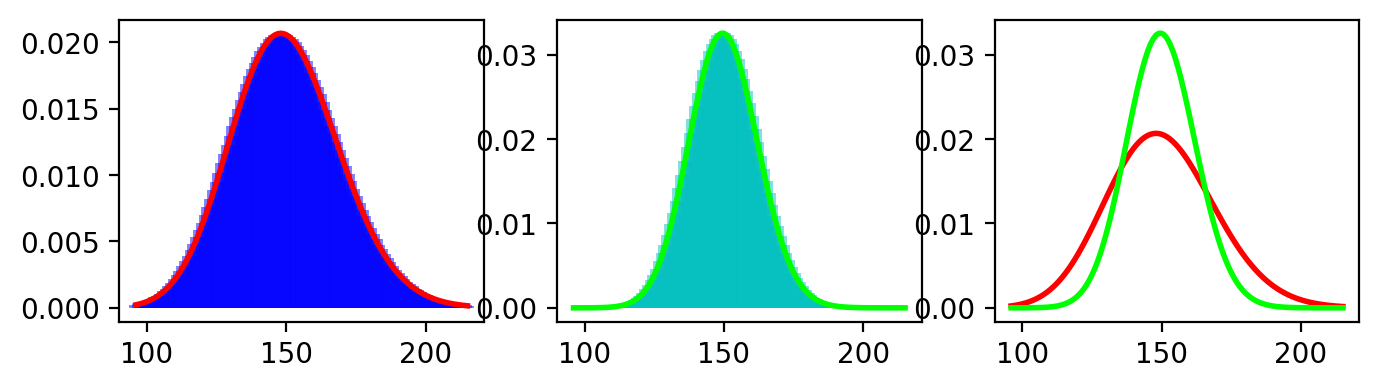

In [51]:
# NEGATIVE BINOMIAL & POISSON DISTRIBUTION
# Plots

plt.figure(figsize=(8,2))

plt.subplot(1, 3, 1)
plt.plot(x, neg_binomial, color=red, linewidth=2)
plt.vlines(x, 0, neg_binomial, colors='b', lw=5, alpha=0.5)

plt.subplot(1, 3, 2)
plt.plot(x, poisson, color=green, linewidth=2)
plt.vlines(x, 0, poisson, colors='c', lw=5, alpha=0.5)

plt.subplot(1, 3, 3)
plt.plot(x, neg_binomial, color=red, linewidth=2)
plt.plot(x, poisson, color=green, linewidth=2)

plt.show()

In [52]:
# Now difference is visible on the 3rd figure (counting from left)
# But we can say that both distributions (negative binomial and poisson)
# are the same because the difference between them equals to 0.01

In [53]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
#                                                         STUDENT FAMILY DISTRIBUTIONS
# -------------------------------------------------------------------------------------------------------------------------------------------------

# Student-t distributions can be considered generalizations of Gaussian distributions with varying scale.
# Use both degrees of freedom and dispersion parametrizations to see how changing parameters moves from normal distribution.
# Take a special case of degrees of freedom equal to 1, as this is Cauchy distribution.
# See how mean and variance behave while you increase number of samples.

In [54]:
student_dict_size = 10000

v = [1, 2, 5, 10, 15, 20] # Degrees of freedom; v = n-1; where n is number of observations
student_dict: dict = {} # Empty dictionary

for param in v:
    student_dict['Student-t v = {}'.format(param)] = np.random.standard_t(param, size = student_dict_size)

In [55]:
# Data frame of student-t family distribution
df_student_dict = pd.DataFrame.from_dict(student_dict)

# print(df_student_dict)

In [56]:
# Melted data frame of student-t family distribution
df_melted_student_dict = df_student_dict.melt()

print(df_melted_student_dict)

               variable     value
0       Student-t v = 1 -1.148019
1       Student-t v = 1  0.754796
2       Student-t v = 1 -1.784791
3       Student-t v = 1  9.282065
4       Student-t v = 1  1.031806
...                 ...       ...
59995  Student-t v = 20  0.848293
59996  Student-t v = 20  0.363669
59997  Student-t v = 20  2.289082
59998  Student-t v = 20 -1.103595
59999  Student-t v = 20 -0.461917

[60000 rows x 2 columns]


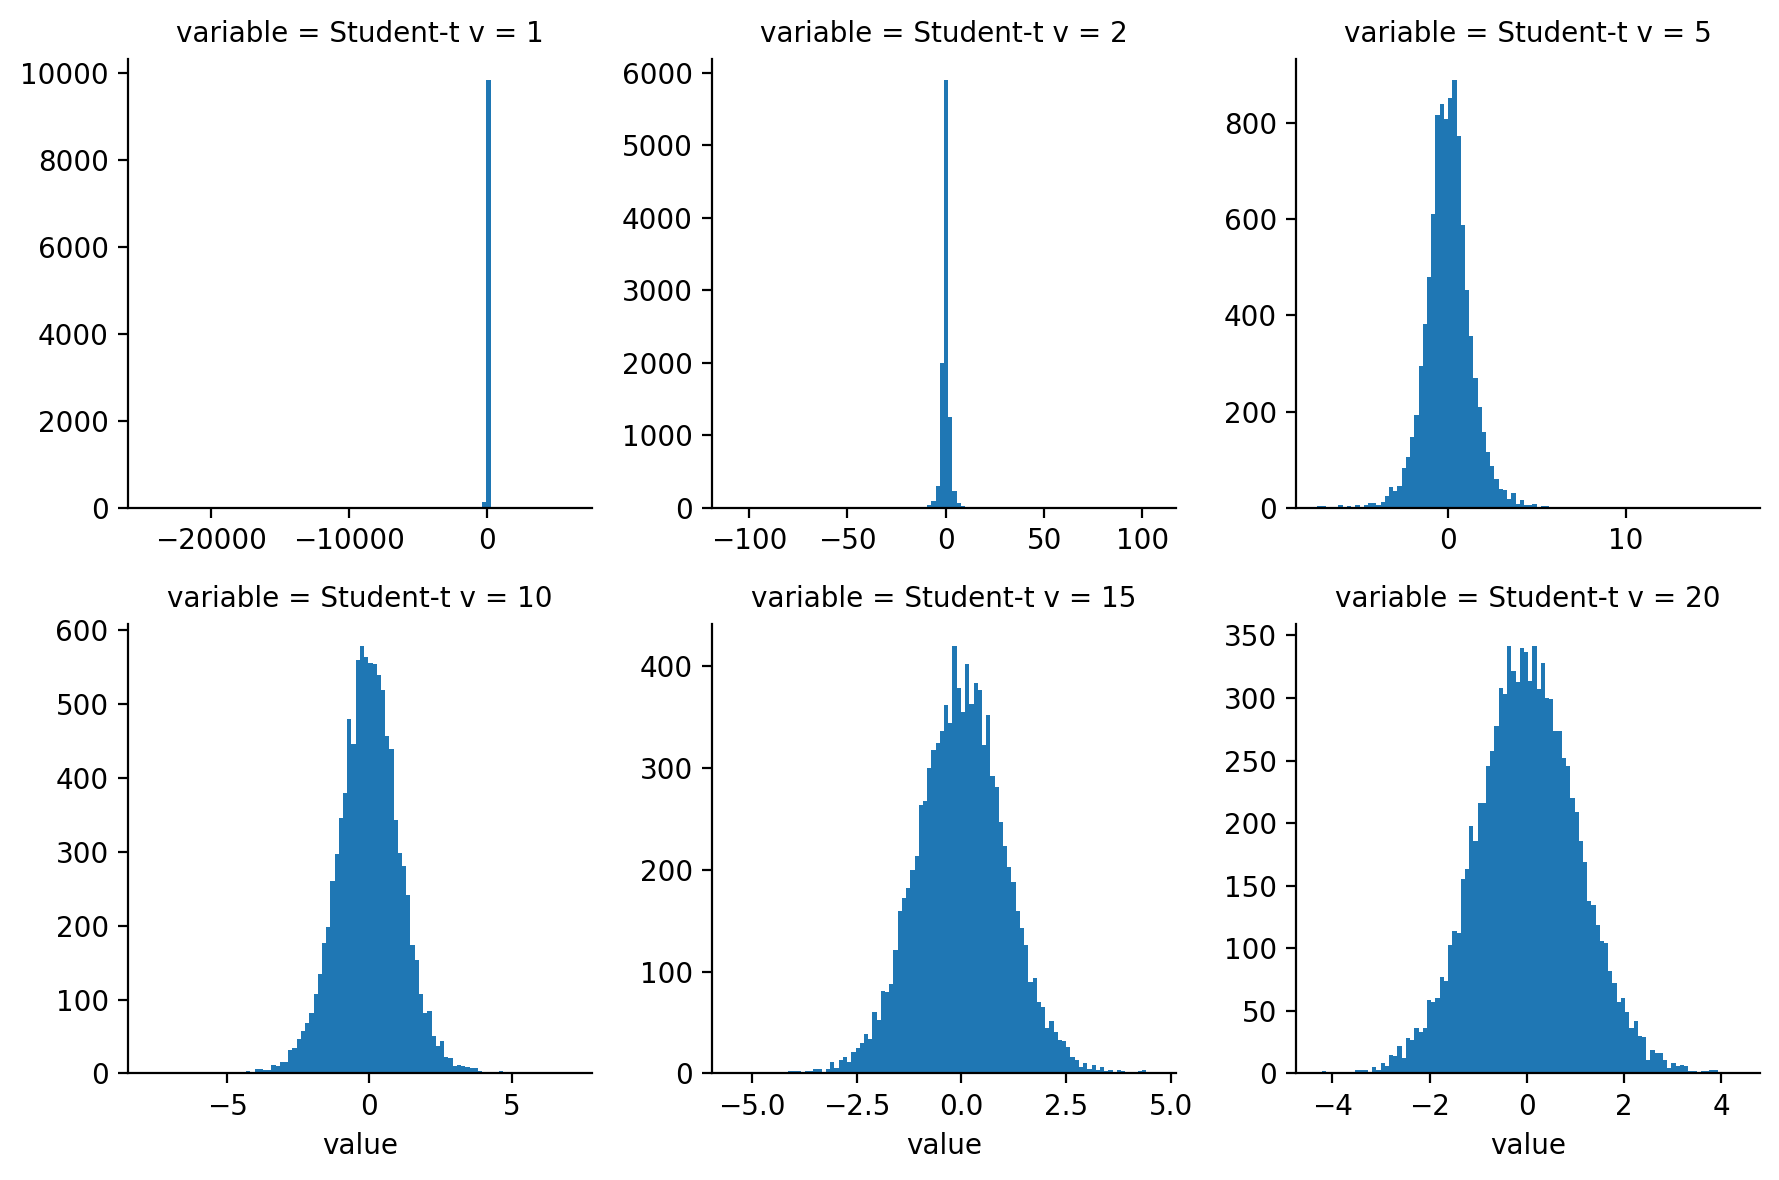

In [57]:
# Histogram of student-t family distribution

Graph = sns.FacetGrid(df_melted_student_dict, col="variable", sharey=False, sharex=False, col_wrap=3)
Graph = Graph.map(plt.hist, "value", cumulative=False, bins=100)

In [58]:
# CAUCHY DISTRIBUTION (degrees of freedom = 1)
# Calculations used in plotting

samples = [10, 100, 1000] # Number of samples

# X variables for various number of samples
x0 = np.linspace(stats.t.ppf(0.01, v[0]),
                 stats.t.ppf(0.99, v[0]),
                 samples[0])

x1 = np.linspace(stats.t.ppf(0.01, v[0]),
                 stats.t.ppf(0.99, v[0]),
                 samples[1])

x2 = np.linspace(stats.t.ppf(0.01, v[0]),
                 stats.t.ppf(0.99, v[0]),
                 samples[2])

# Student-t distribution for various number of samples
student0 = stats.t.pdf(x0, v[0])
student1 = stats.t.pdf(x1, v[0])
student2 = stats.t.pdf(x2, v[0])

# Normal distribution for various number of samples
normal0 = stats.norm.pdf(x0)
normal1 = stats.norm.pdf(x1)
normal2 = stats.norm.pdf(x2)

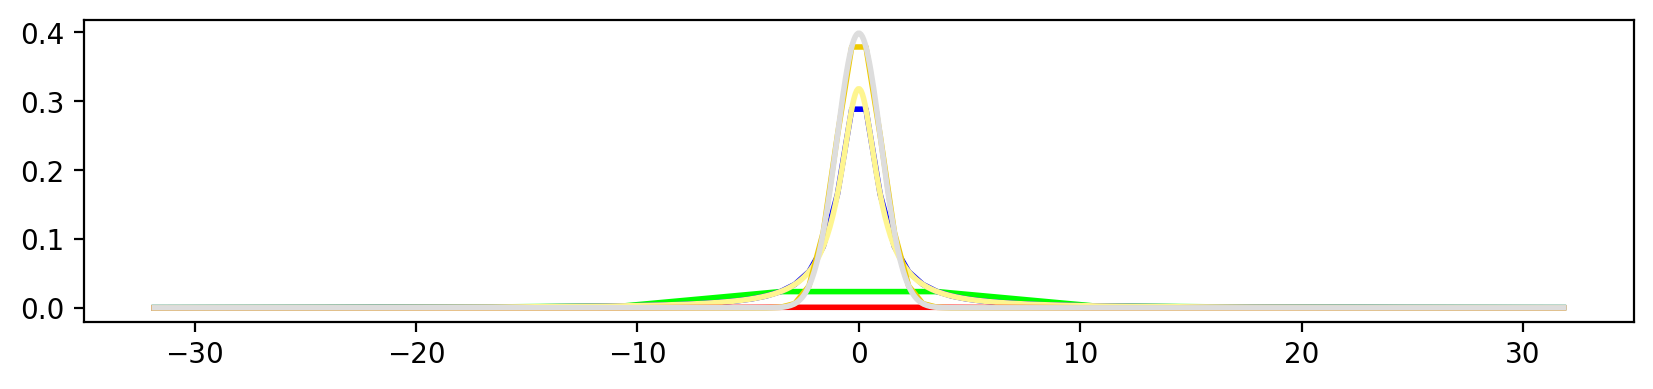

In [59]:
# CAUCHY DISTRIBUTION (degrees of freedom = 1)
# Plots

plt.figure(figsize=(10,2))

plt.plot(x0, student0, color=green, linewidth=2)
plt.plot(x1, student1, color=blue, linewidth=2)
plt.plot(x2, student2, color=light_highlight, linewidth=2)

plt.plot(x0, normal0, color=red, linewidth=2)
plt.plot(x1, normal1, color=dark, linewidth=2)
plt.plot(x2, normal2, color=light_grey, linewidth=2)

plt.show()

In [60]:
# STUDENT-T MODEL

# Print file content
with open('student_t.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> nu; // Deg of freedom
    real mu; //Location
    real<lower=0> sigma; //Scale
}

parameters {
    real y;
}

model {
    y ~ student_t(nu, mu, sigma);
}


In [61]:
# Build model based on algebra_solver file
model_student = stan_utility.compile_model('student_t.stan')

Using cached StanModel


[INFO] Iterations: 10
[SUMMARY] Inference for Stan model: anon_model_f07fc4284241dbd088191ef1e2de2591.
1 chains, each with iter=10; warmup=5; thin=1; 
post-warmup draws per chain=5, total post-warmup draws=5.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -3.85    0.25    0.7  -4.64  -4.53   -3.6  -3.36  -2.99      8   2.91
lp__  -2.74    0.11   0.34  -3.11  -3.07  -2.64   -2.5  -2.29      9   2.59

Samples were drawn using NUTS at Thu Jun 11 17:30:27 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
[INFO] Iterations: 100
[SUMMARY] Inference for Stan model: anon_model_f07fc4284241dbd088191ef1e2de2591.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -0.62    2.29    9.0  -27.3  -2.53   -0.3 

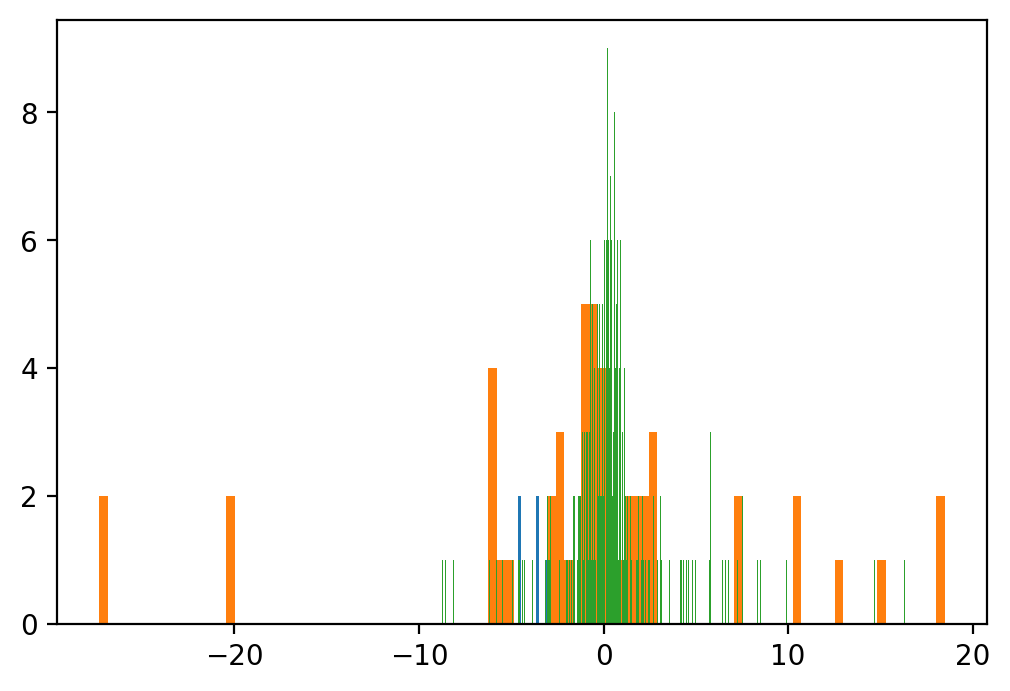

In [62]:
iterations = [10, 100, 500]

for iter in iterations:
    sim_student = model_student.sampling(data = {'nu': 1.0,
                                                 'mu': 0.0,
                                                 'sigma': 1.0
                                                },
                                         iter = iter,
                                         chains = 1,
                                         seed = 42342)
    stundet_model_results = sim_student.extract()
    Graph = plt.hist(stundet_model_results['y'], bins=iter)
    print('[INFO] Iterations: {iter}\n[SUMMARY] {stansum}'.format(iter=iter, stansum=sim_student.stansummary()))

In [63]:
# NU = 1.0; MU = 0.0; SIGMA = 1.0
sim_student = model_student.sampling(data={'nu': 1.0,
                                           'mu': 0.0,
                                           'sigma': 1.0
                                          },
                                     iter = 500,
                                     chains = 1,
                                     seed = 42342)
model_student_results = sim_student.extract()

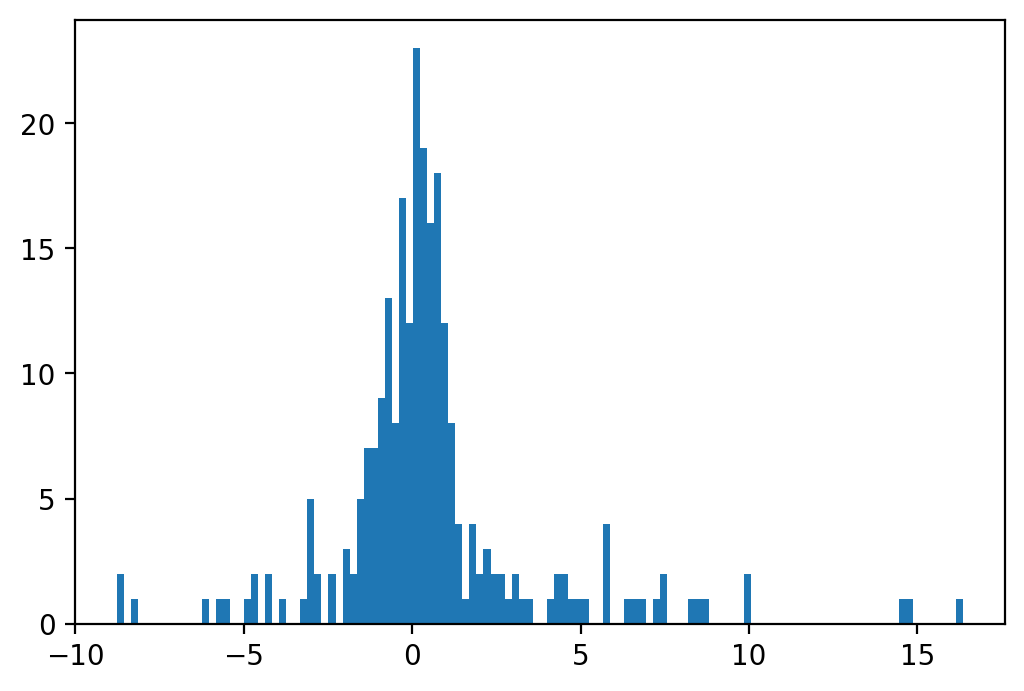

In [64]:
Graph = plt.hist(model_student_results['y'], bins=120)

In [65]:
print(sim_student.stansummary())

Inference for Stan model: anon_model_f07fc4284241dbd088191ef1e2de2591.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      0.55    0.35    3.1  -5.11  -0.69   0.21   0.92   8.53     79    1.0
lp__   -1.1     0.2   1.31  -4.34   -1.6  -0.54  -0.12-2.0e-3     44    1.0

Samples were drawn using NUTS at Thu Jun 11 17:30:28 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [66]:
# NU = 2.0; MU = 0.0; SIGMA = 1.0
sim_student = model_student.sampling(data={'nu': 2.0,
                                           'mu': 0.0,
                                           'sigma': 1.0
                                          },
                                     iter = 500,
                                     chains = 1,
                                     seed = 42342)
model_student_results = sim_student.extract()

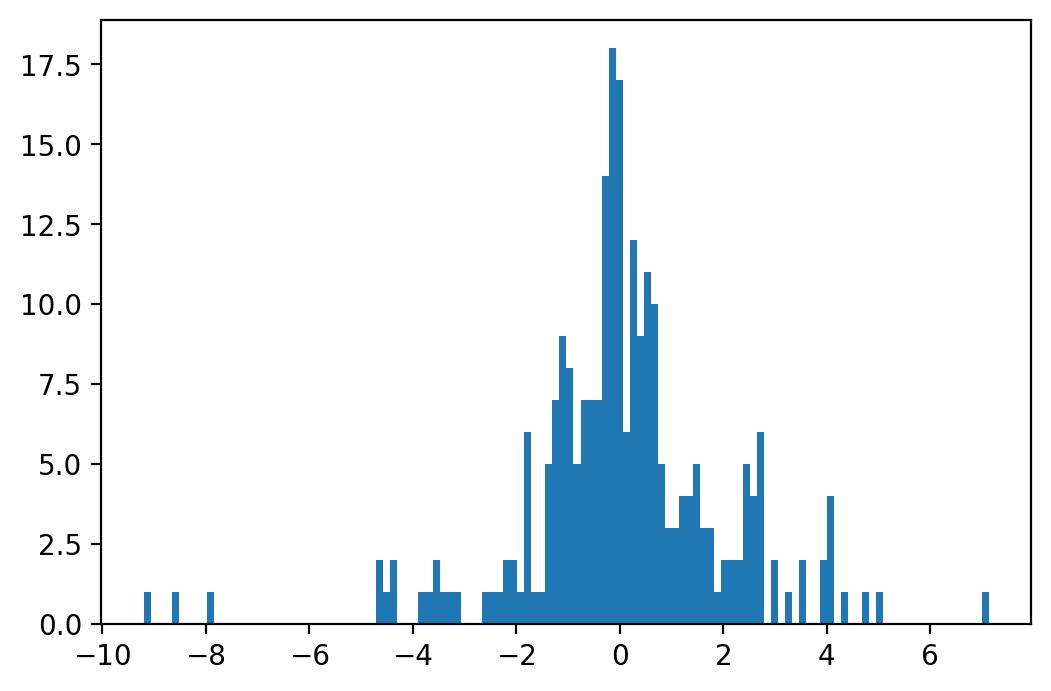

In [67]:
Graph = plt.hist(model_student_results['y'], bins=120)

In [68]:
print(sim_student.stansummary())

Inference for Stan model: anon_model_f07fc4284241dbd088191ef1e2de2591.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      0.05    0.21   1.98  -4.37  -0.81  -0.02   0.86   4.02     87    1.0
lp__  -0.95    0.15   1.17  -3.73  -1.45  -0.45  -0.07-9.2e-4     64    1.0

Samples were drawn using NUTS at Thu Jun 11 17:30:29 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [69]:
# NU = 1.0; MU = 0.0; SIGMA = 2.0
sim_student = model_student.sampling(data={'nu': 1.0,
                                           'mu': 0.0,
                                           'sigma': 2.0
                                          },
                                     iter = 500,
                                     chains = 1,
                                     seed = 42342)
model_student_results = sim_student.extract()

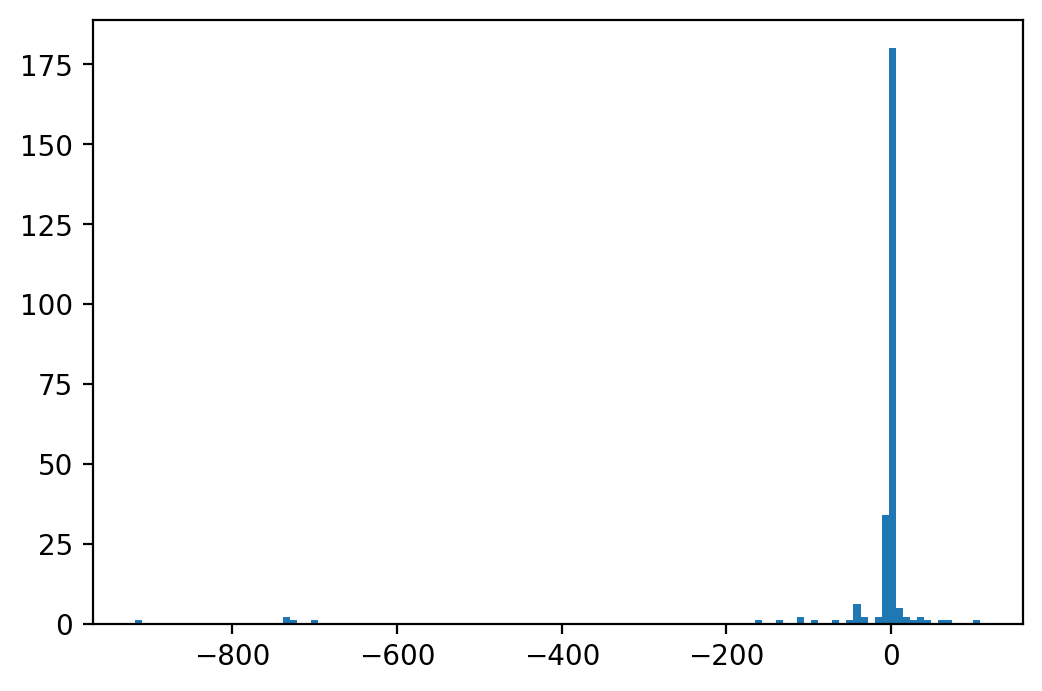

In [70]:
Graph = plt.hist(model_student_results['y'], bins=120)

In [71]:
print(sim_student.stansummary())

Inference for Stan model: anon_model_f07fc4284241dbd088191ef1e2de2591.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y    -18.07   15.77 109.49 -143.9  -2.49  -0.33   1.77  30.46     48   1.02
lp__  -1.62    0.52   2.38  -8.54  -1.71  -0.81  -0.22-4.3e-3     21   1.02

Samples were drawn using NUTS at Thu Jun 11 17:30:29 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [72]:
# NU = 2.0; MU = 0.0; SIGMA = 2.0
sim_student = model_student.sampling(data={'nu': 2.0,
                                           'mu': 0.0,
                                           'sigma': 2.0
                                          },
                                     iter = 500,
                                     chains = 1,
                                     seed = 42342)
model_student_results = sim_student.extract()

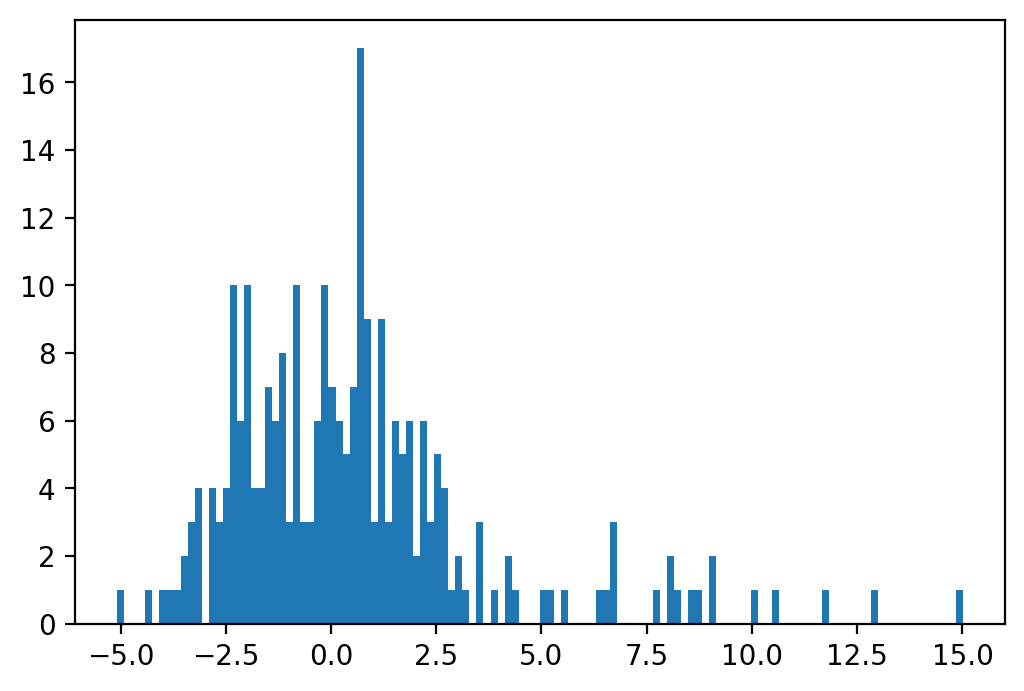

In [73]:
Graph = plt.hist(model_student_results['y'], bins=120)

In [74]:
print(sim_student.stansummary())

Inference for Stan model: anon_model_f07fc4284241dbd088191ef1e2de2591.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      0.56    0.32   3.07  -3.51  -1.51   0.15   1.63   9.04     90    1.0
lp__  -0.71    0.11   0.94  -3.62  -0.85  -0.38  -0.11-8.5e-4     78    1.0

Samples were drawn using NUTS at Thu Jun 11 17:30:30 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [75]:
# NU = 1.0; MU = 1.0; SIGMA = 1.0
sim_student = model_student.sampling(data={'nu': 1.0,
                                           'mu': 1.0,
                                           'sigma': 1.0
                                          },
                                     iter = 500,
                                     chains = 1,
                                     seed = 42342)
model_student_results = sim_student.extract()

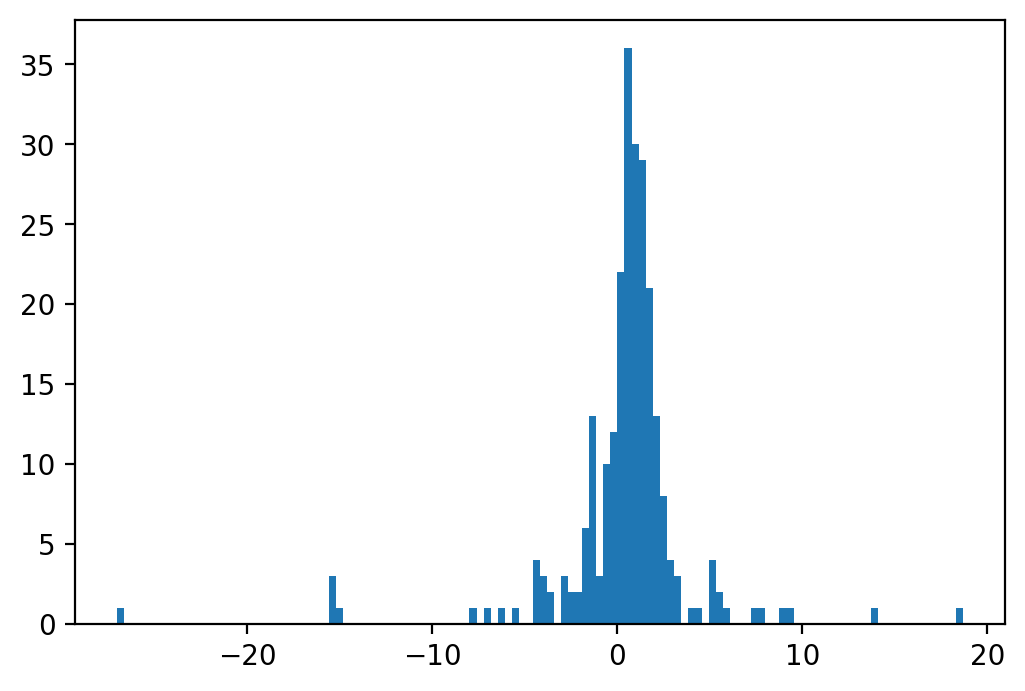

In [76]:
Graph = plt.hist(model_student_results['y'], bins=120)

In [77]:
print(sim_student.stansummary())

Inference for Stan model: anon_model_f07fc4284241dbd088191ef1e2de2591.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      0.42    0.43   3.72  -7.39  -0.18   0.75   1.57   6.44     73    1.0
lp__  -1.07    0.25   1.34  -5.29  -1.68  -0.45   -0.1-4.8e-4     28    1.0

Samples were drawn using NUTS at Thu Jun 11 17:30:30 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [78]:
# NU = 1.0; MU = -1.0; SIGMA = 1.0
sim_student = model_student.sampling(data={'nu': 1.0,
                                           'mu': -1.0,
                                           'sigma': 1.0
                                          },
                                     iter = 500,
                                     chains = 1,
                                     seed = 42342)
model_student_results = sim_student.extract()

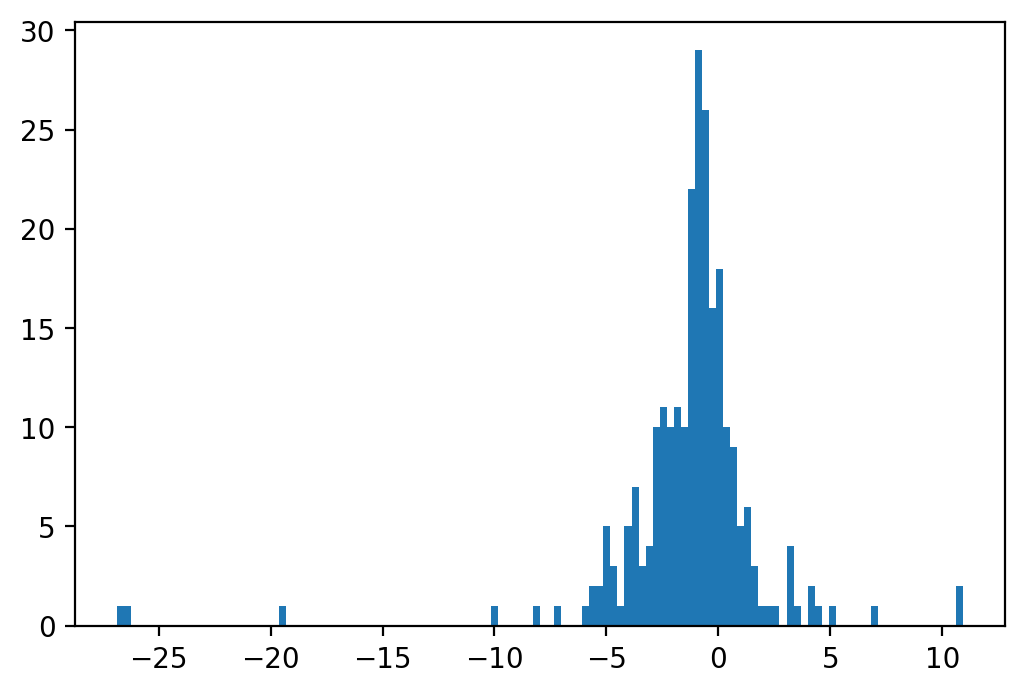

In [79]:
Graph = plt.hist(model_student_results['y'], bins=120)

In [80]:
print(sim_student.stansummary())

Inference for Stan model: anon_model_f07fc4284241dbd088191ef1e2de2591.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -1.29     0.4   3.46  -6.41  -2.23  -0.91  -0.05   4.22     74   1.01
lp__   -1.1    0.19   1.21  -4.27  -1.64  -0.71  -0.14-1.9e-3     40    1.0

Samples were drawn using NUTS at Thu Jun 11 17:30:31 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [81]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
#                                                         MULTIVARIATE NORMAL DISTRIBUTIONS
# -------------------------------------------------------------------------------------------------------------------------------------------------

# Consider density plots and 2d histograms for visualisation of behavior of 2 dimensional Multivariate normal.
# Use the correlation matrix decompositon of covariance matrix to see how individual variances and correlations infulence the distribution.
# For 3 and 4 dimensional normal distributions observe the marginals of variables with histograms.

In [82]:
# MULTI_NORMAL MODEL

# Print file content
with open('multi_normal.stan', 'r') as file:
    print(file.read())

data {
    vector[2] mu; //location vector
    matrix[2,2] Sigma; //covariance matrix
}

parameters {
    vector[2] y;
}

model {
    y ~ multi_normal(mu, Sigma);
}


In [83]:
# Build model based on algebra_solver file
model_multi_normal = stan_utility.compile_model('multi_normal.stan')

Using cached StanModel


In [84]:
mean = [0, 0]
cov = [(1, 0.5), (0.5, 1)]

sim_multi_normal = model_multi_normal.sampling(data={'mu': mean,
                                                     'Sigma': cov
                                                    },
                                               iter = 10000,
                                               seed = 43541)

In [85]:
multi_normal_model_results = sim_multi_normal.extract()

# print(multi_normal_model_results)

In [86]:
print(sim_multi_normal.stansummary())

Inference for Stan model: anon_model_2c0527d257029df57827adc7864cba99.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y[1]   0.02    0.01   0.99  -1.92  -0.64   0.02   0.69   1.99   8583    1.0
y[2]   0.02    0.01    1.0  -1.92  -0.65   0.02   0.68   2.01   8557    1.0
lp__  -0.98    0.01   0.99  -3.62  -1.38  -0.68  -0.27  -0.02   8273    1.0

Samples were drawn using NUTS at Thu Jun 11 17:30:32 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


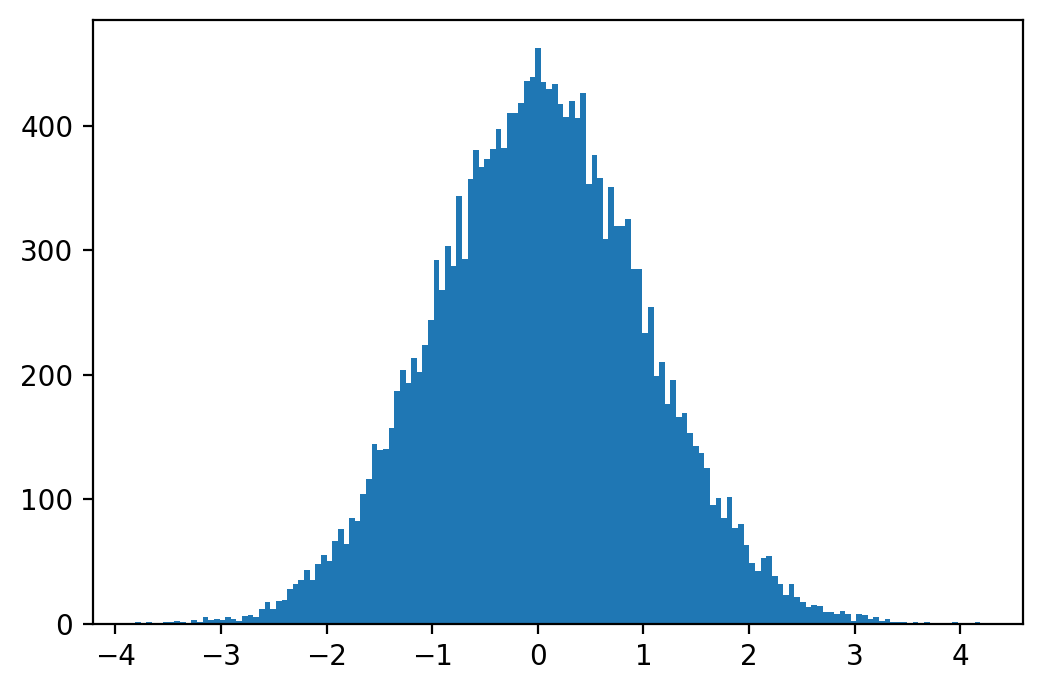

In [87]:
# MEAN=0; COV=(1, 0.5)
Graph1 = plt.hist(multi_normal_model_results['y'][:,0], bins=150)

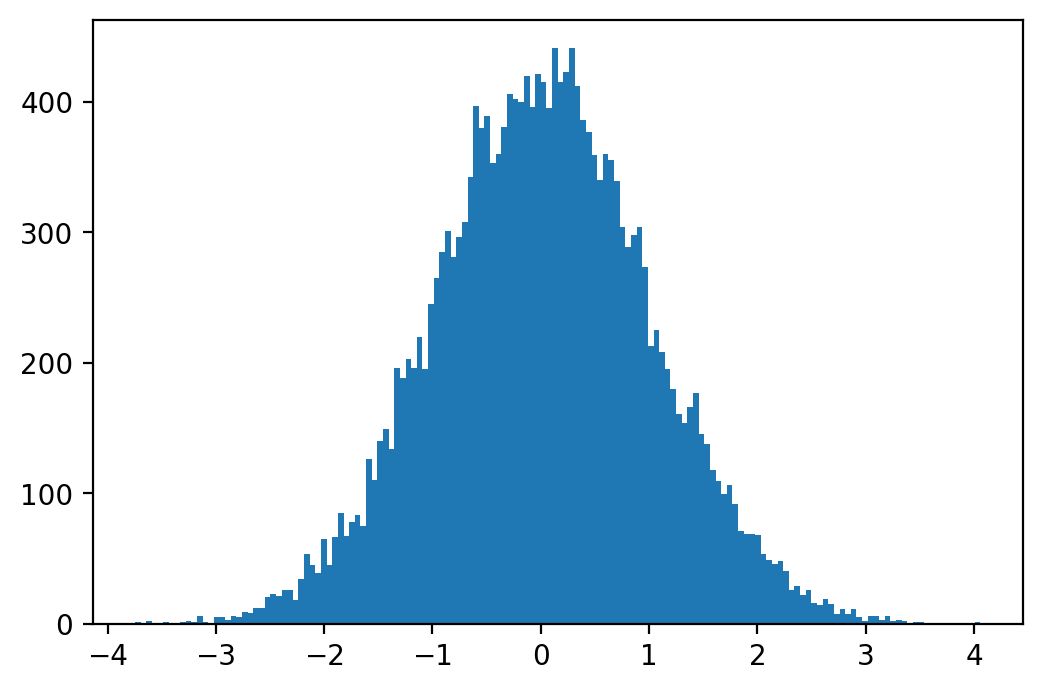

In [88]:
# MEAN=0; COV=(0.5, 1)
Graph2 = plt.hist(multi_normal_model_results['y'][:,1], bins=150)

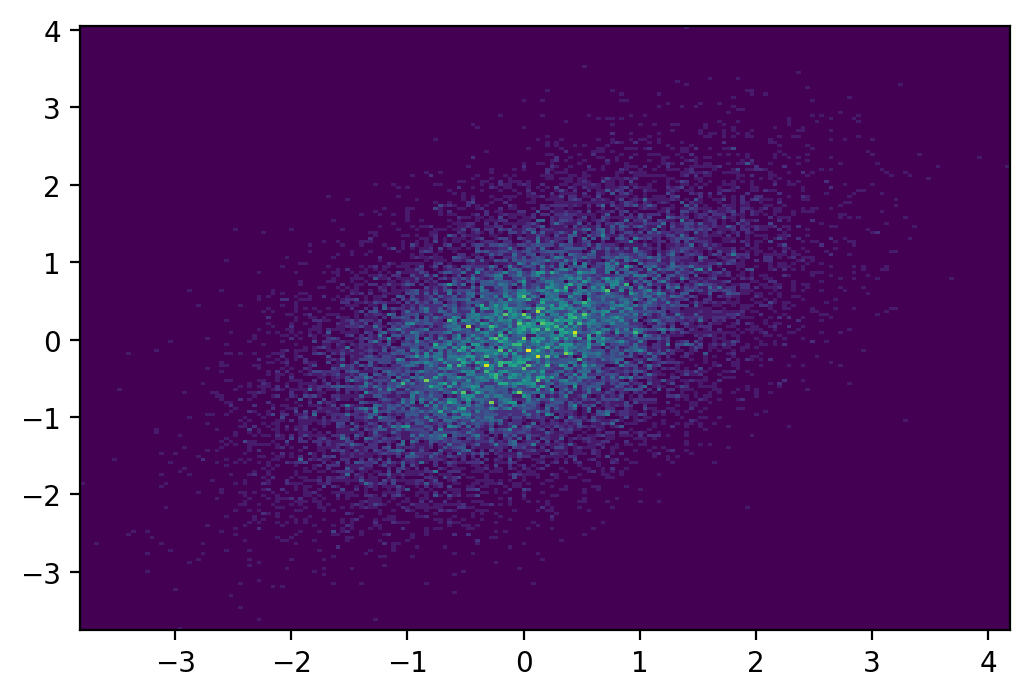

In [89]:
Graph = plt.hist2d(multi_normal_model_results['y'][:,0], multi_normal_model_results['y'][:,1], bins=200)

In [90]:
x1 = pd.Series(multi_normal_model_results['y'][:,0], name="$Y_1$")
x2 = pd.Series(multi_normal_model_results['y'][:,1], name="$Y_2$")

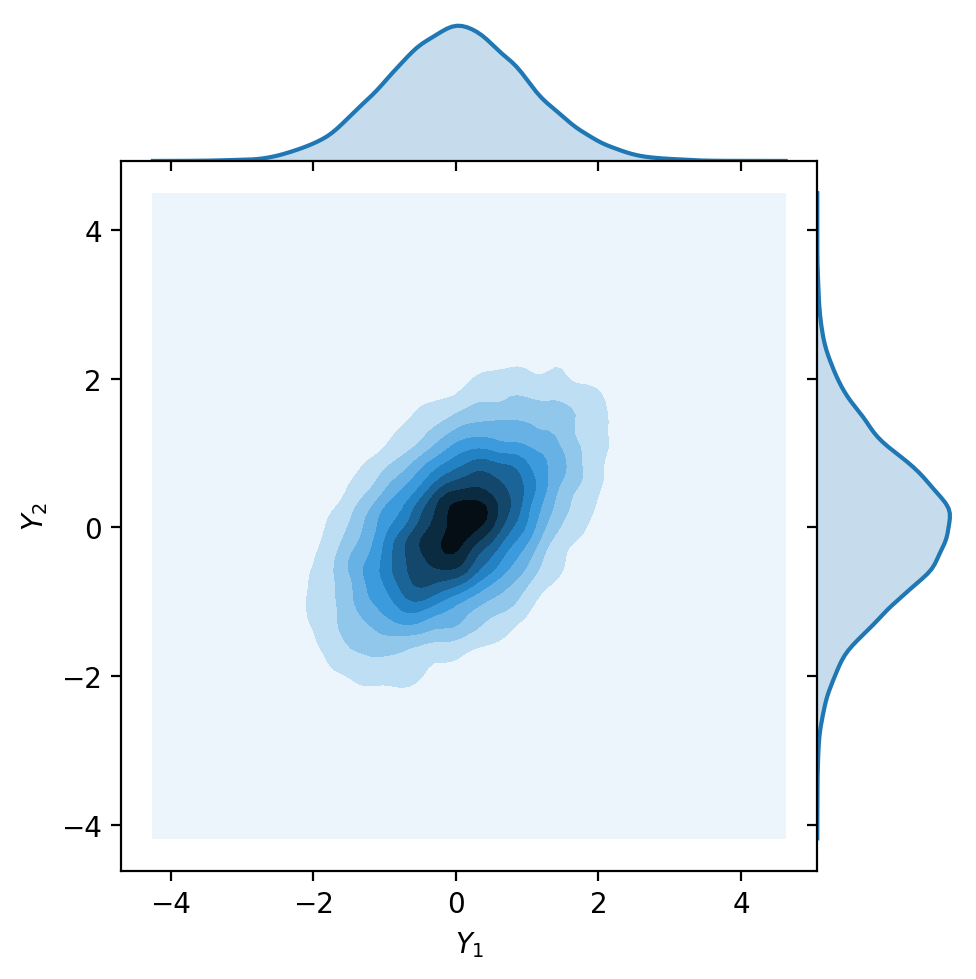

In [91]:
# Joint distribution
# kernel density estimation
sns.jointplot(x1, x2, kind="kde", height=5, space=0)

In [92]:
mean = [2, 0]
cov = [(1, 0.5), (0.5, 1)]

sim_multi_normal = model_multi_normal.sampling(data={'mu': mean,
                                                     'Sigma': cov
                                                    },
                                               iter = 10000,
                                               seed = 43541)

In [93]:
multi_normal_model_results = sim_multi_normal.extract()

# print(multi_normal_model_results)

In [94]:
x1 = pd.Series(multi_normal_model_results['y'][:,0], name="$Y_1$")
x2 = pd.Series(multi_normal_model_results['y'][:,1], name="$Y_2$")

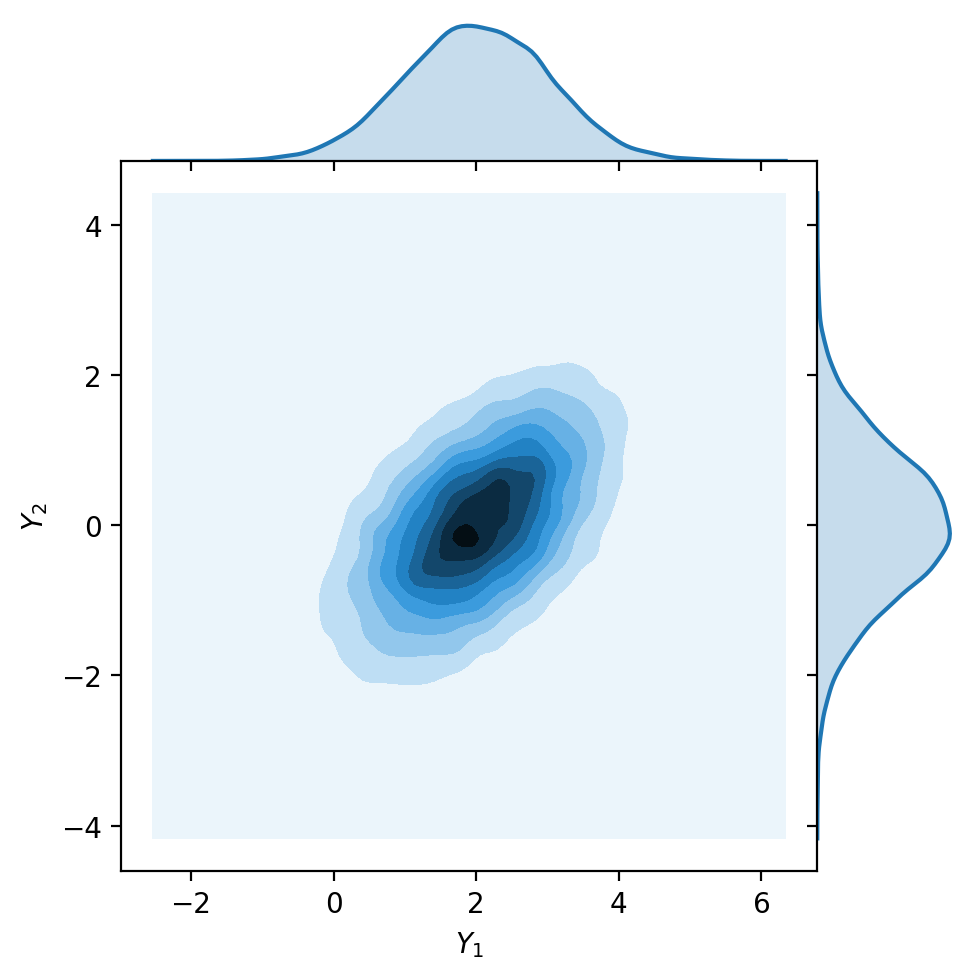

In [95]:
# Joint distribution
# kernel density estimation
sns.jointplot(x1, x2, kind="kde", height=5,space=0)

In [96]:
mean = [0, 0]
cov = [(1, 0.0), (0.0, 1)]

sim_multi_normal = model_multi_normal.sampling(data={'mu': mean,
                                                     'Sigma': cov
                                                    },
                                               iter = 10000,
                                               seed = 43541)

In [97]:
multi_normal_model_results = sim_multi_normal.extract()

# print(multi_normal_model_results)

In [98]:
x1 = pd.Series(multi_normal_model_results['y'][:,0], name="$Y_1$")
x2 = pd.Series(multi_normal_model_results['y'][:,1], name="$Y_2$")

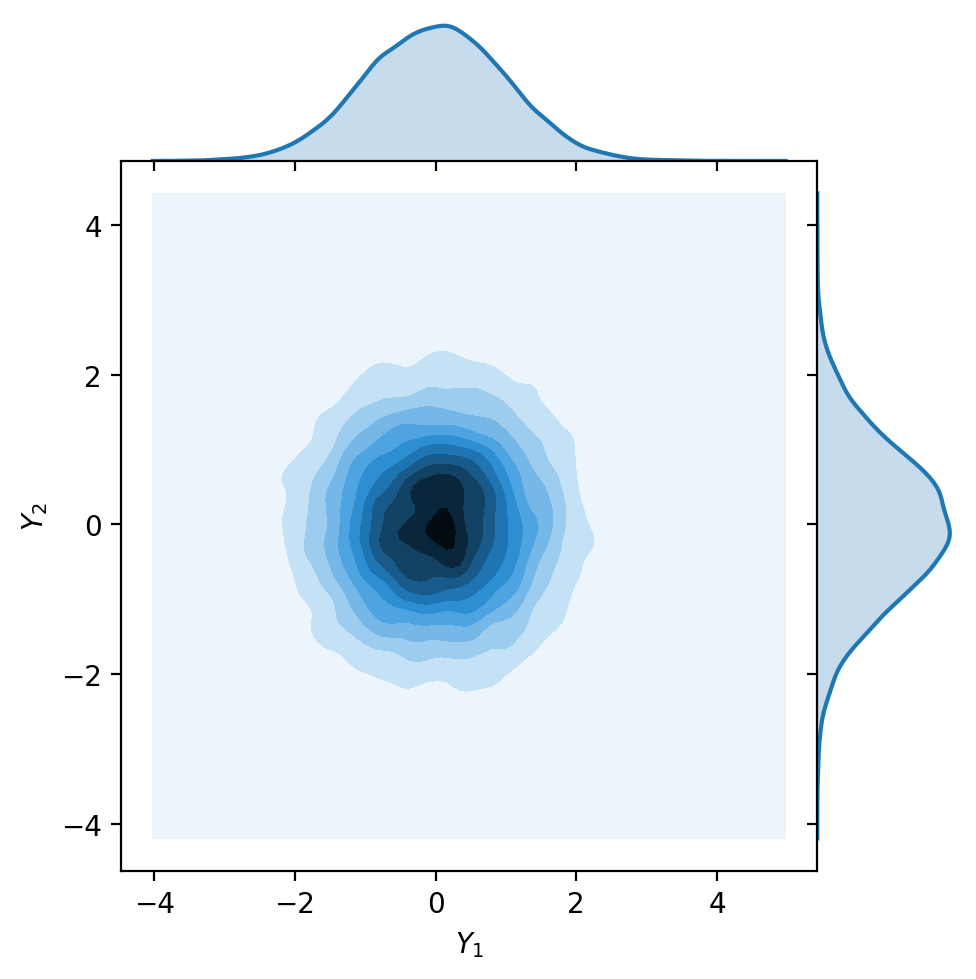

In [99]:
# Joint distribution
# kernel density estimation
sns.jointplot(x1, x2, kind="kde", height=5, space=0)

In [100]:
# MULTI_NORMAL_N MODEL

# Print file content
with open('multi_normal_N.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N; //Number of dim
    vector[N] mu; //location vector
    matrix[N,N] Sigma; //covariance matrix
}

parameters {
    vector[N] y;
}

model {
    y ~ multi_normal(mu, Sigma);
}


In [101]:
model_multi_normal_n = stan_utility.compile_model('multi_normal_N.stan')

Using cached StanModel


In [102]:
mean = [0, 0, 0]
cov = [(1, 0.5, 0.3), (0.5, 1, 0.5), (0.3, 0.5, 1)]

sim_model_multi_normal_n = model_multi_normal_n.sampling(data = {'N' : len(mean),
                                                                 'mu': mean,
                                                                 'Sigma': cov
                                                                },
                                                         iter = 1000,
                                                         seed = 43541)

In [103]:
multi_normal_n_model_results = sim_model_multi_normal_n.extract()

# print(multi_normal_n_model_results)

In [104]:
print(sim_model_multi_normal_n.stansummary())

Inference for Stan model: anon_model_d3559db38eae9d51d79b87578e6d95ea.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y[1]   0.03    0.03   1.03  -1.96  -0.69   0.01   0.74   2.06   1193    1.0
y[2]   0.05    0.03   1.01  -1.92  -0.64   0.06   0.75   1.99   1195    1.0
y[3]   0.02    0.03   1.01  -2.06  -0.66   0.04    0.7   1.96   1334    1.0
lp__  -1.51    0.04   1.19  -4.83  -2.03  -1.21  -0.69  -0.12    866    1.0

Samples were drawn using NUTS at Thu Jun 11 17:31:21 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [105]:
# Dictionary of multivariate normal distribution

multi_normal_dict = { 'y_1' : sim_model_multi_normal_n['y'][:,0],
                      'y_2' : sim_model_multi_normal_n['y'][:,1],
                      'y_3' : sim_model_multi_normal_n['y'][:,2]
                    }

In [106]:
# Data frame of multivariate normal distribution
df_multi_normal_dict = pd.DataFrame(multi_normal_dict)

# print(df_multi_normal_dict)

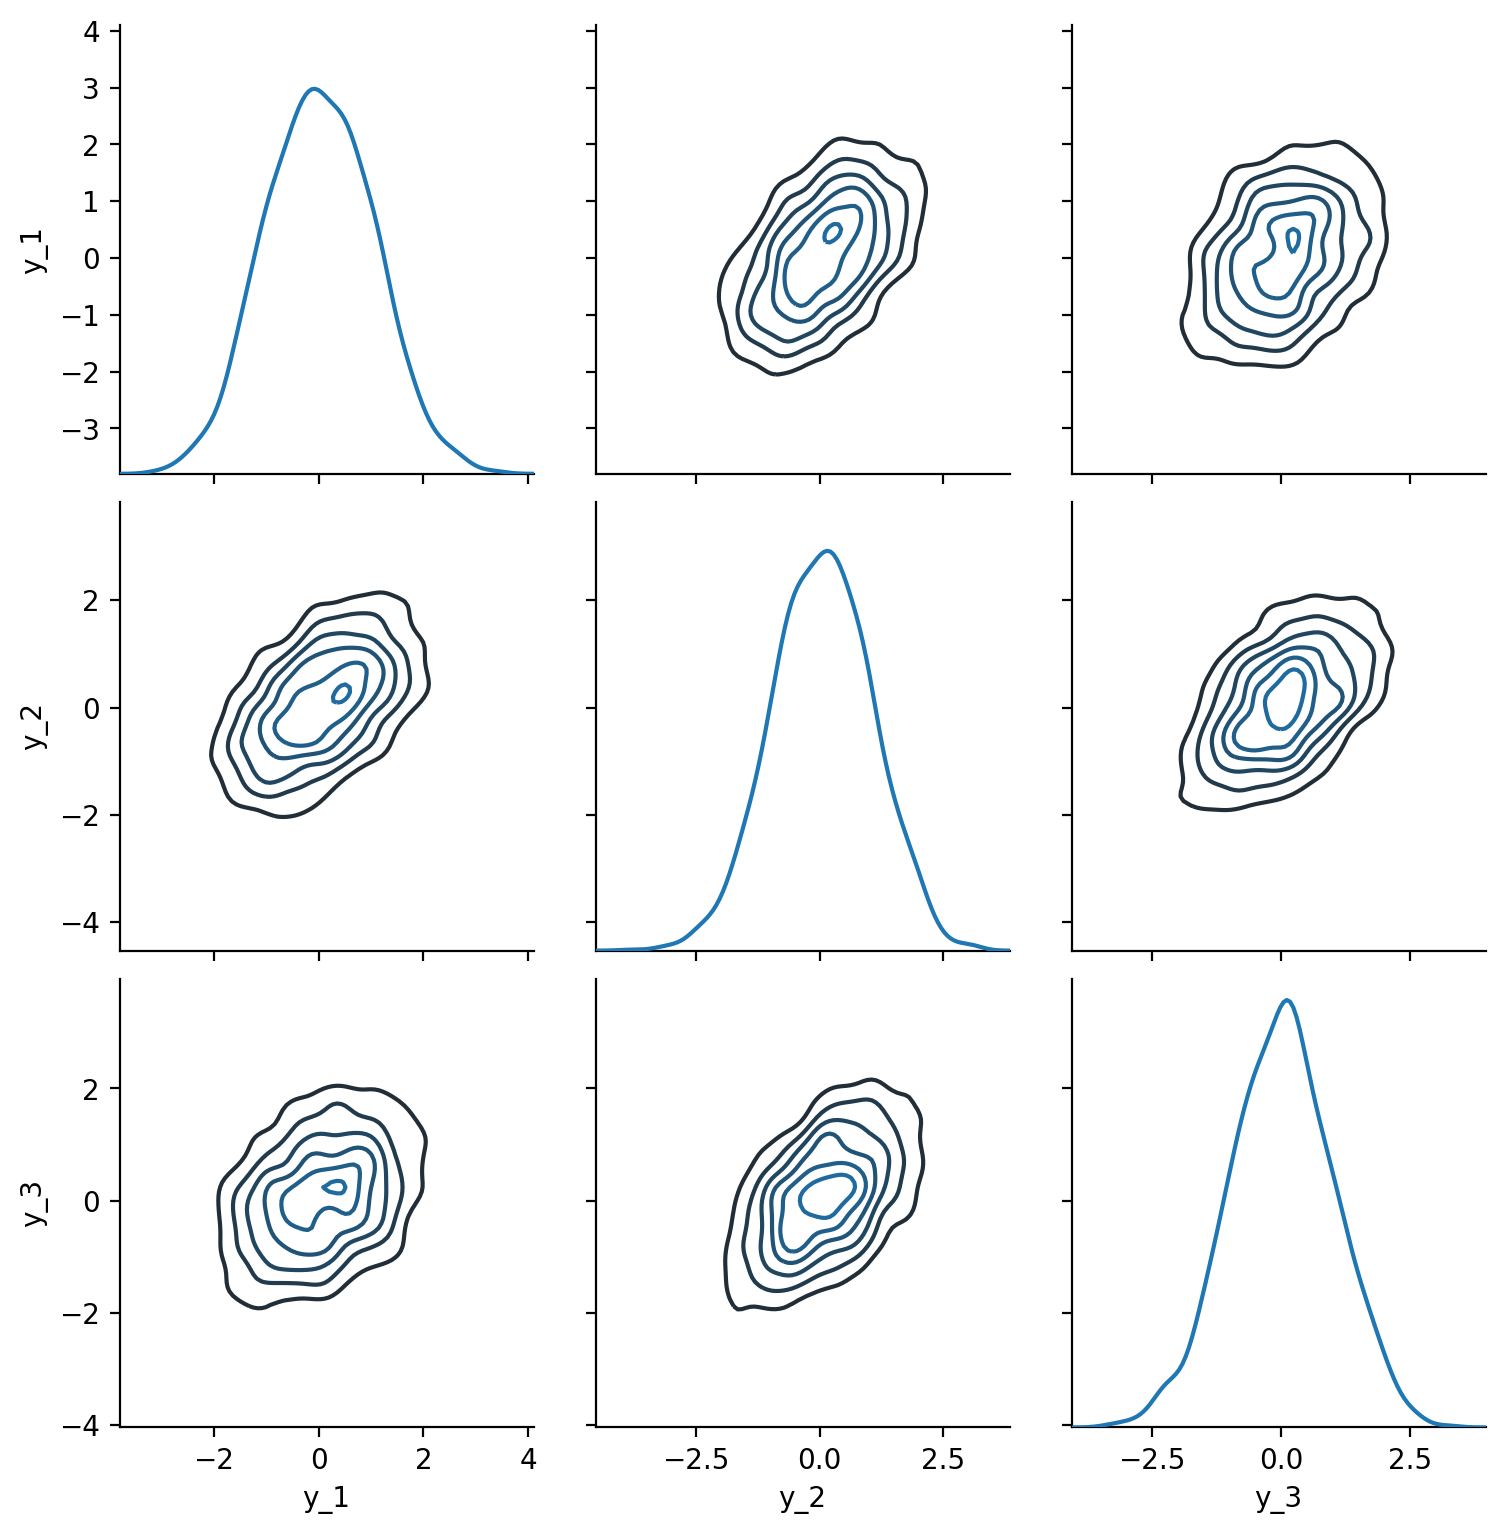

In [107]:
Graph = sns.PairGrid(df_multi_normal_dict)
Graph.map_diag(sns.kdeplot)
Graph.map_offdiag(sns.kdeplot, n_levels=6);

In [108]:
mean = [0, 0, 0]
cov = [(1, 0.2, 0.2), (0.2, 1, 0.2), (0.2, 0.2, 1)]

sim_model_multi_normal_n = model_multi_normal_n.sampling(data = {'N' : len(mean),
                                                                 'mu': mean,
                                                                 'Sigma': cov
                                                                },
                                                         iter = 1000,
                                                         seed = 43541)

In [109]:
multi_normal_n_model_results = sim_model_multi_normal_n.extract()

# print(multi_normal_n_model_results)

In [110]:
# Dictionary of multivariate normal distribution

multi_normal_dict = { 'y_1' : sim_model_multi_normal_n['y'][:,0],
                      'y_2' : sim_model_multi_normal_n['y'][:,1],
                      'y_3' : sim_model_multi_normal_n['y'][:,2]
                    }

In [111]:
# Data frame of multivariate normal distribution
df_multi_normal_dict = pd.DataFrame(multi_normal_dict)

# print(df_multi_normal_dict)

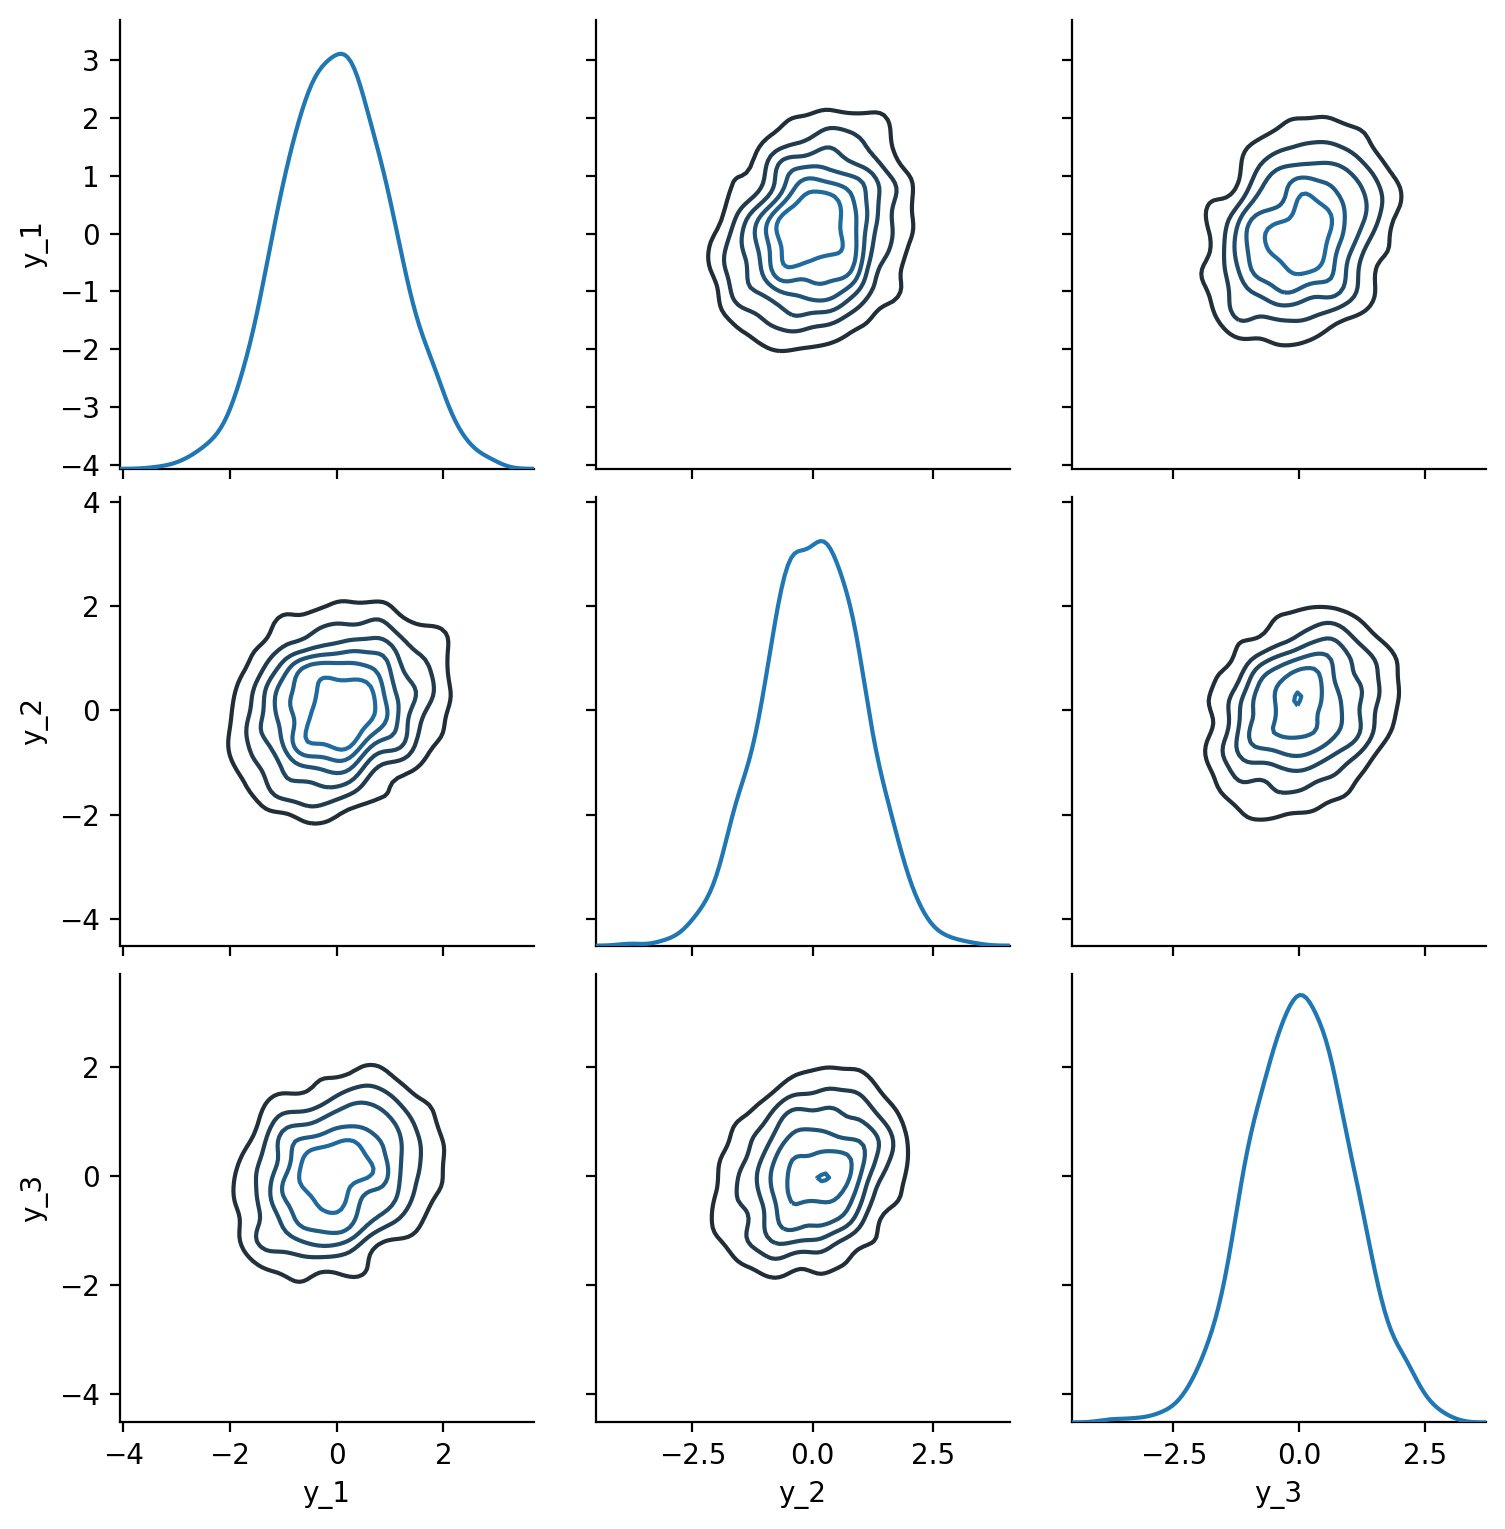

In [112]:
Graph = sns.PairGrid(df_multi_normal_dict)
Graph.map_diag(sns.kdeplot)
Graph.map_offdiag(sns.kdeplot, n_levels=6);

In [113]:
mean = [0, 0, 0, 0]
cov = [(1, 0.2, 0.2, 0.2), (0.2, 1, 0.2, 0.2), (0.2, 0.2, 1, 0.2), (0.2, 0.2, 0.2, 1)]

sim_model_multi_normal_n = model_multi_normal_n.sampling(data = {'N' : len(mean),
                                                                 'mu': mean,
                                                                 'Sigma': cov
                                                                },
                                                         iter = 1000,
                                                         seed = 43541)

In [114]:
multi_normal_n_model_results = sim_model_multi_normal_n.extract()

# print(multi_normal_n_model_results)

In [115]:
# Dictionary of multivariate normal distribution

multi_normal_dict = { 'y_1' : sim_model_multi_normal_n['y'][:,0],
                      'y_2' : sim_model_multi_normal_n['y'][:,1],
                      'y_3' : sim_model_multi_normal_n['y'][:,2],
                      'y_4' : sim_model_multi_normal_n['y'][:,3]
                    }

In [116]:
# Data frame of multivariate normal distribution
df_multi_normal_dict = pd.DataFrame(multi_normal_dict)

# print(df_multi_normal_dict)

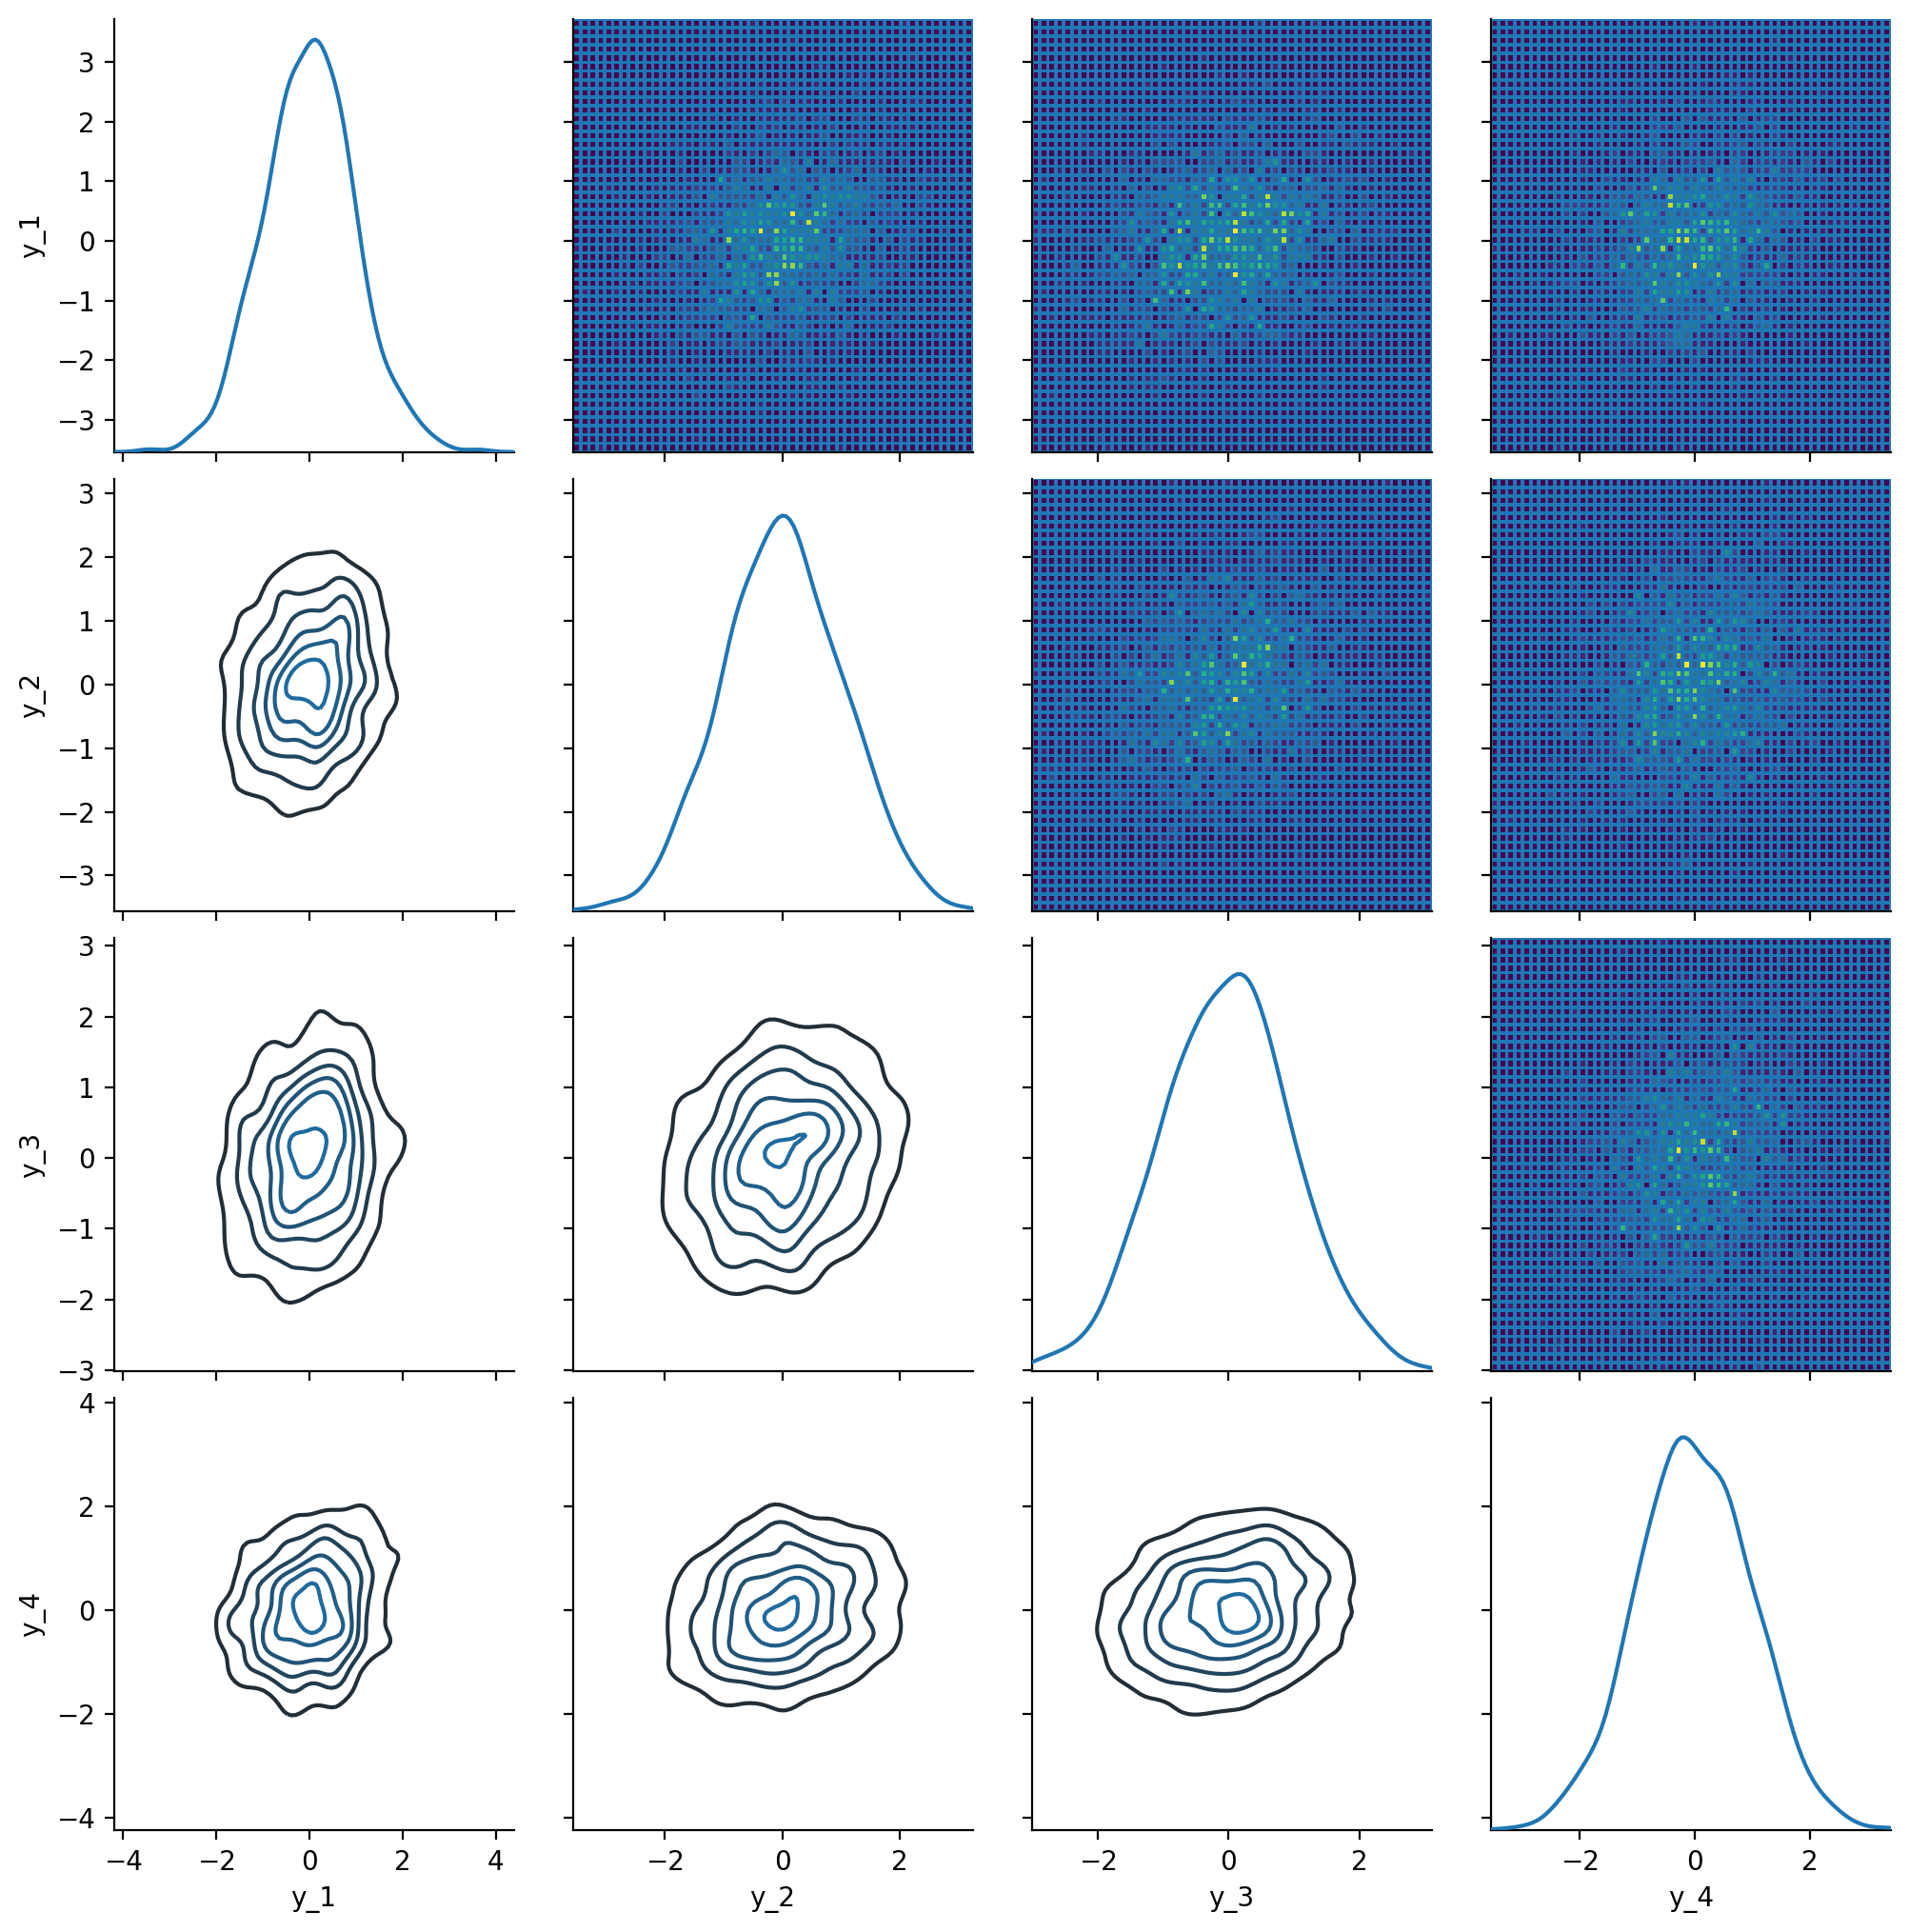

In [117]:
Graph = sns.PairGrid(df_multi_normal_dict)
Graph.map_diag(sns.kdeplot)
Graph.map_upper(plt.hist2d, bins=50)
Graph.map_lower(sns.kdeplot, n_levels=6)